# Categorical Regression

In [1]:
from typing import Dict, Tuple, List

import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pyt
import xarray as xr
from scipy import special

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

# Crepe Toppings
* find the winning crepe topping for each strata

In [4]:
individual_answers = pd.read_csv("../data/crepes-toppings.csv", index_col=0)
print(individual_answers.shape)
individual_answers.head()

(500, 10)


Broccoli  Nutella  Peanut Butter  Salted Caramel  Sugar       age  \
0         0        0              0               1      0  2.385732   
1         0        0              0               1      0  0.658382   
2         0        1              0               0      0  0.924508   
3         0        1              0               0      0 -0.207614   
4         0        1              0               0      0  0.236649   

  nationality  nationality_idx winning_topping  winning_topping_idx  
0       Other                3  Salted Caramel                    3  
1      French                0  Salted Caramel                    3  
2       Other                3         Nutella                    1  
3     Italian                2         Nutella                    1  
4     Italian                2         Nutella                    1

In [5]:
individual_answers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Broccoli             500 non-null    int64  
 1   Nutella              500 non-null    int64  
 2   Peanut Butter        500 non-null    int64  
 3   Salted Caramel       500 non-null    int64  
 4   Sugar                500 non-null    int64  
 5   age                  500 non-null    float64
 6   nationality          500 non-null    object 
 7   nationality_idx      500 non-null    int64  
 8   winning_topping      500 non-null    object 
 9   winning_topping_idx  500 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 43.0+ KB


In [6]:
individual_answers.describe().round(2)

Broccoli  Nutella  Peanut Butter  Salted Caramel   Sugar     age  \
count    500.00   500.00         500.00          500.00  500.00  500.00   
mean       0.03     0.41           0.12            0.30    0.13   -0.05   
std        0.18     0.49           0.33            0.46    0.34    1.00   
min        0.00     0.00           0.00            0.00    0.00   -2.94   
25%        0.00     0.00           0.00            0.00    0.00   -0.69   
50%        0.00     0.00           0.00            0.00    0.00   -0.04   
75%        0.00     1.00           0.00            1.00    0.00    0.60   
max        1.00     1.00           1.00            1.00    1.00    2.77   

       nationality_idx  winning_topping_idx  
count           500.00               500.00  
mean              1.38                 2.09  
std               1.13                 1.17  
min               0.00                 0.00  
25%               0.00                 1.00  
50%               1.00                 2.00  
75%               2.00                 3.00  
max               3.00                 4.00

In [8]:
num_toppings = 5
toppings = individual_answers.columns[:num_toppings]
toppings

Index(['Broccoli', 'Nutella', 'Peanut Butter', 'Salted Caramel', 'Sugar'], dtype='object')

In [10]:
individual_answers.groupby("nationality")[toppings].sum().T

nationality     French  German  Italian  Other
Broccoli             3      11        1      2
Nutella             57      25       73     49
Peanut Butter       12      21       13     15
Salted Caramel      71      24       36     20
Sugar               14      18       20     15

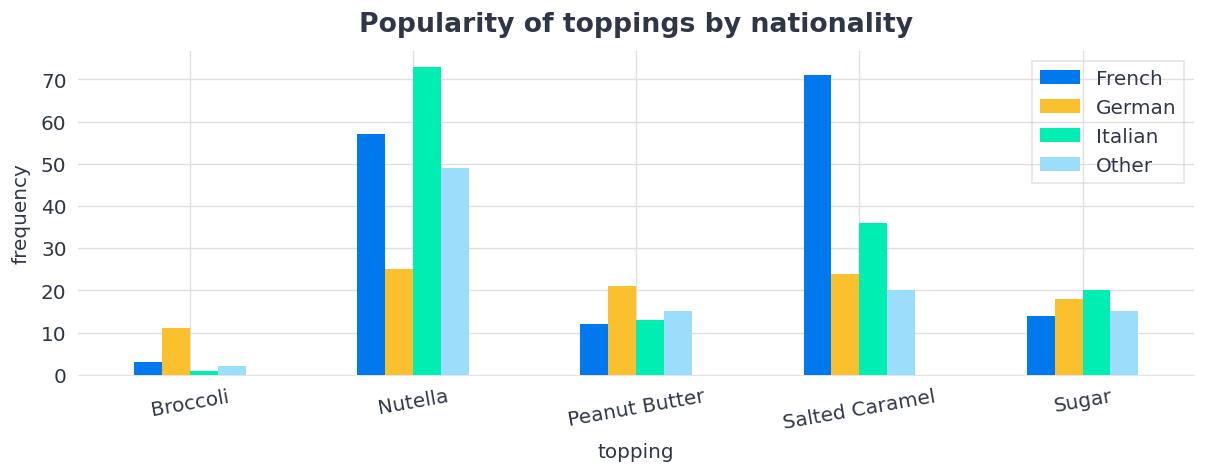

In [23]:
ax = individual_answers.groupby("nationality")[toppings].sum().T.plot(
    kind="bar", rot=10, figsize=(12, 3.5)
)
ax.set(xlabel="topping", ylabel="frequency", title="Popularity of toppings by nationality")
ax.legend(loc="upper right", frameon=True)
plt.show()

### PyMC ZeroSumNormal

In [24]:
winning_topping_idx = individual_answers["winning_topping_idx"].to_numpy()

In [25]:
nationalities_idx, nationalities = individual_answers["nationality"].factorize(
    sort=True
)

In [26]:
toppings_coords = {
    "toppings": toppings,
    "obs_idx": individual_answers.index,
    "nationality": nationalities,
}
toppings_coords

{'toppings': Index(['Broccoli', 'Nutella', 'Peanut Butter', 'Salted Caramel', 'Sugar'], dtype='object'),
 'obs_idx': Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
        ...
        490, 491, 492, 493, 494, 495, 496, 497, 498, 499],
       dtype='int64', length=500),
 'nationality': Index(['French', 'German', 'Italian', 'Other'], dtype='object')}

In [30]:
scales = [0.1, 1, 10]

In [31]:
def create_categorical_model(df: pd.DataFrame, coords: Dict,  sigma: float, verbose: bool=False) -> pm.Model:

    with pm.Model(coords=coords) as categorical_model:
        # data
        age = pm.MutableData("age", df["age"], dims="obs_idx")
        nationalities_id = pm.MutableData(
            "nationalities_id", df["nationality_idx"], dims="obs_idx"
        )  # categorical value (index)
        winning_topping = pm.MutableData(
            "winning_topping", df["winning_topping_idx"], dims="obs_idx"
        )

        ##### parameters #####
        # intercept for each class (topping)
        intercepts = pm.ZeroSumNormal("intercepts", sigma=sigma, dims="toppings")  
        # (age) slope for each class
        β_age = pm.ZeroSumNormal("β_age", sigma=sigma, dims="toppings")  
        # offset for each nationality (for each topping). Apply zerosum constraint on both axes (nationality and toppings)
        β_nationality = pm.ZeroSumNormal(
            "β_nationality", sigma=sigma, dims=("nationality", "toppings"), zerosum_axes=2
        )
        
        if verbose:
            print(f"intercepts shape: {intercepts.eval().shape}")
            print(f"intecepts (broadcast) shape: {intercepts[None].eval().shape}")
            print(f"age slope shape: {β_age.eval().shape}")
            print(f"age outer product: {pyt.outer(age, β_age).eval().shape}")
            print(f"nationality offset shape: {β_nationality.eval().shape}")
            print(f"nationality offset (broadcast) shape: {β_nationality[nationalities_id].eval().shape}")

        # linear regression
        # dims=("obs_idx", "toppings")
        p = pm.math.softmax(
            intercepts[None] + β_nationality[nationalities_id] + pyt.outer(age, β_age),
            axis=-1,
        )
        if verbose:
            print(f"probs. shape = {p.eval().shape}")
            assert np.allclose(p.eval().sum(axis=1), np.ones(len(df))), "probabilities don't sum to 1"
        # likelihood
        _ = pm.Categorical("y", p=p, observed=winning_topping, dims="obs_idx")

    return categorical_model

In [32]:
small_cat_model = create_categorical_model(
    df=individual_answers,
    coords=toppings_coords,
    sigma=scales[0],
    verbose=True
)

intercepts shape: (5,)
intecepts (broadcast) shape: (1, 5)
age slope shape: (5,)
age outer product: (500, 5)
nationality offset shape: (4, 5)
nationality offset (broadcast) shape: (500, 5)
probs. shape = (500, 5)


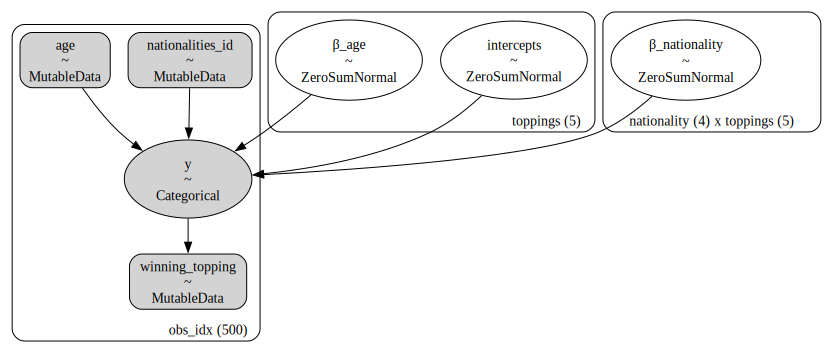

In [33]:
pm.model_to_graphviz(small_cat_model)

In [34]:
medium_cat_model = create_categorical_model(
    df=individual_answers,
    coords=toppings_coords,
    sigma=scales[1]
)

In [35]:
large_cat_model = create_categorical_model(
    df=individual_answers,
    coords=toppings_coords,
    sigma=scales[-1],
)

In [36]:
with small_cat_model:
    small_cat_idata = pm.sample(chains=4, random_seed=1234)
    small_cat_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(small_cat_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercepts, β_age, β_nationality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Sampling: [intercepts, y, β_age, β_nationality]
Sampling: [y]


In [37]:
with medium_cat_model:
    medium_cat_idata = pm.sample(chains=4, random_seed=1234)
    medium_cat_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(medium_cat_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercepts, β_age, β_nationality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [intercepts, y, β_age, β_nationality]
Sampling: [y]


In [38]:
with large_cat_model:
    large_cat_idata = pm.sample(chains=4, random_seed=1234)
    large_cat_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(large_cat_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercepts, β_age, β_nationality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
Sampling: [intercepts, y, β_age, β_nationality]
Sampling: [y]


In [3]:
def plot_forward_samples(idata: az.InferenceData, targets: List[str], title: str, rotation: int=30):
    fig, (left, right) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, layout="constrained")
    xticks = [i + 0.5 for i in range(len(targets))]

    az.plot_ppc(idata, group="prior", ax=left)
    left.set(
        xticks=xticks,
        title="Prior Retrodictive Check",
    )
    left.set_xticklabels(targets, fontsize=14, rotation=rotation)
    left.set_xlabel("Topping", fontsize=16)
    left.legend(frameon=True, fontsize=11)

    az.plot_ppc(idata, ax=right)
    right.set(
        xticks=xticks,
        title="Posterior Retrodictive Check",
    )
    right.set_xticklabels(targets, fontsize=14, rotation=rotation)
    right.set_xlabel("Topping", fontsize=16)
    right.legend(frameon=True, fontsize=11)
    fig.suptitle(title)

### Discussion
* as $\sigma$ increases, there is higher dispersion in the prior, and the sampling is usually longer
    * the posterior should be effected by how much the prior is informative

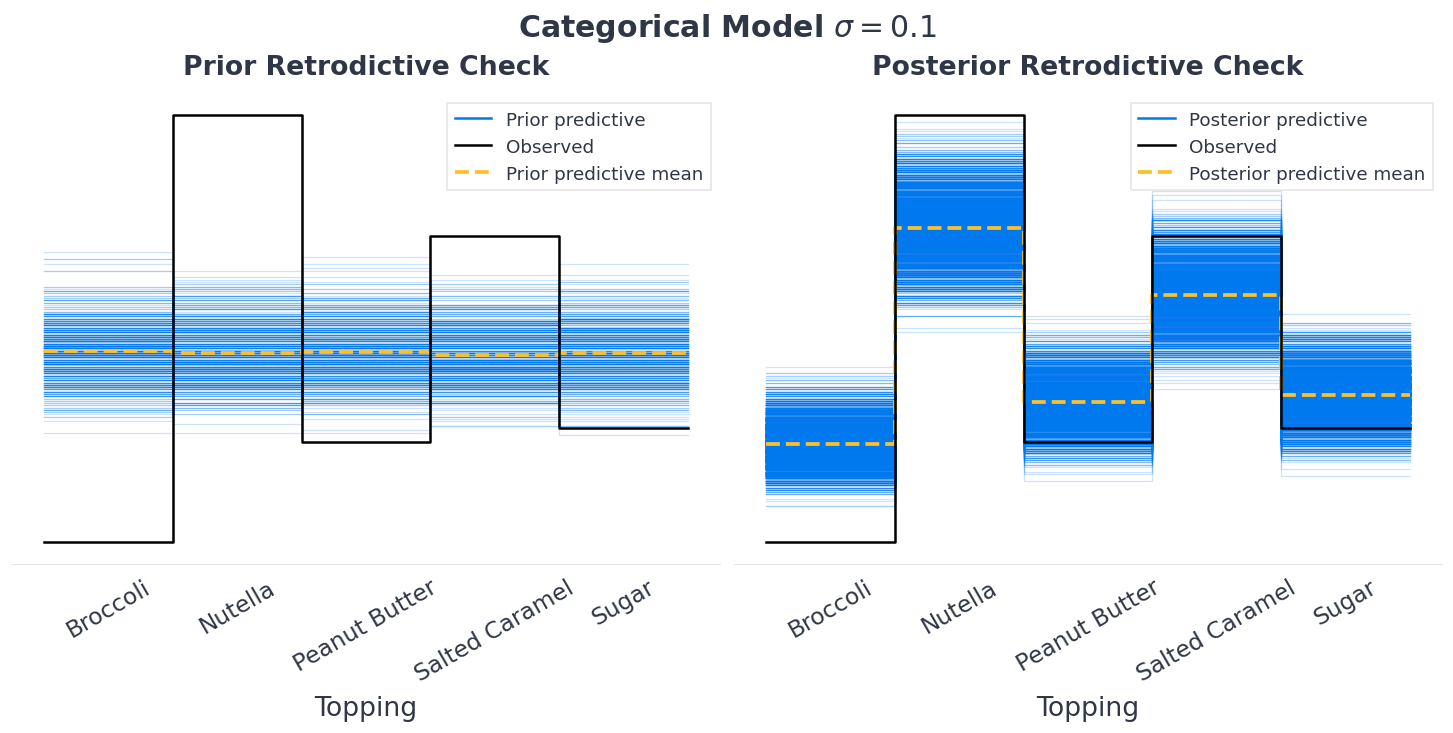

In [40]:
plot_forward_samples(small_cat_idata, targets=toppings, title=fr"Categorical Model $\sigma={scales[0]}$")

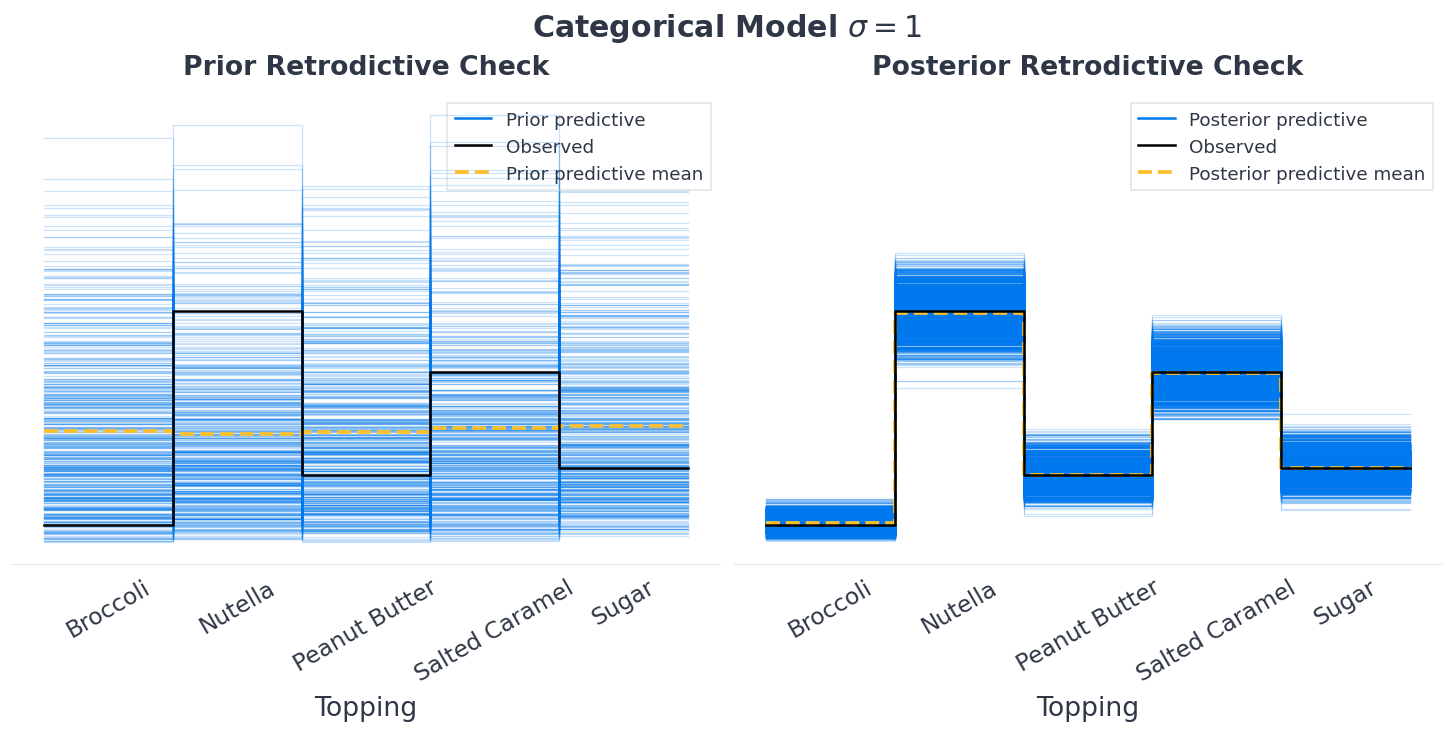

In [41]:
plot_forward_samples(medium_cat_idata, targets=toppings, title=fr"Categorical Model $\sigma={scales[1]}$")

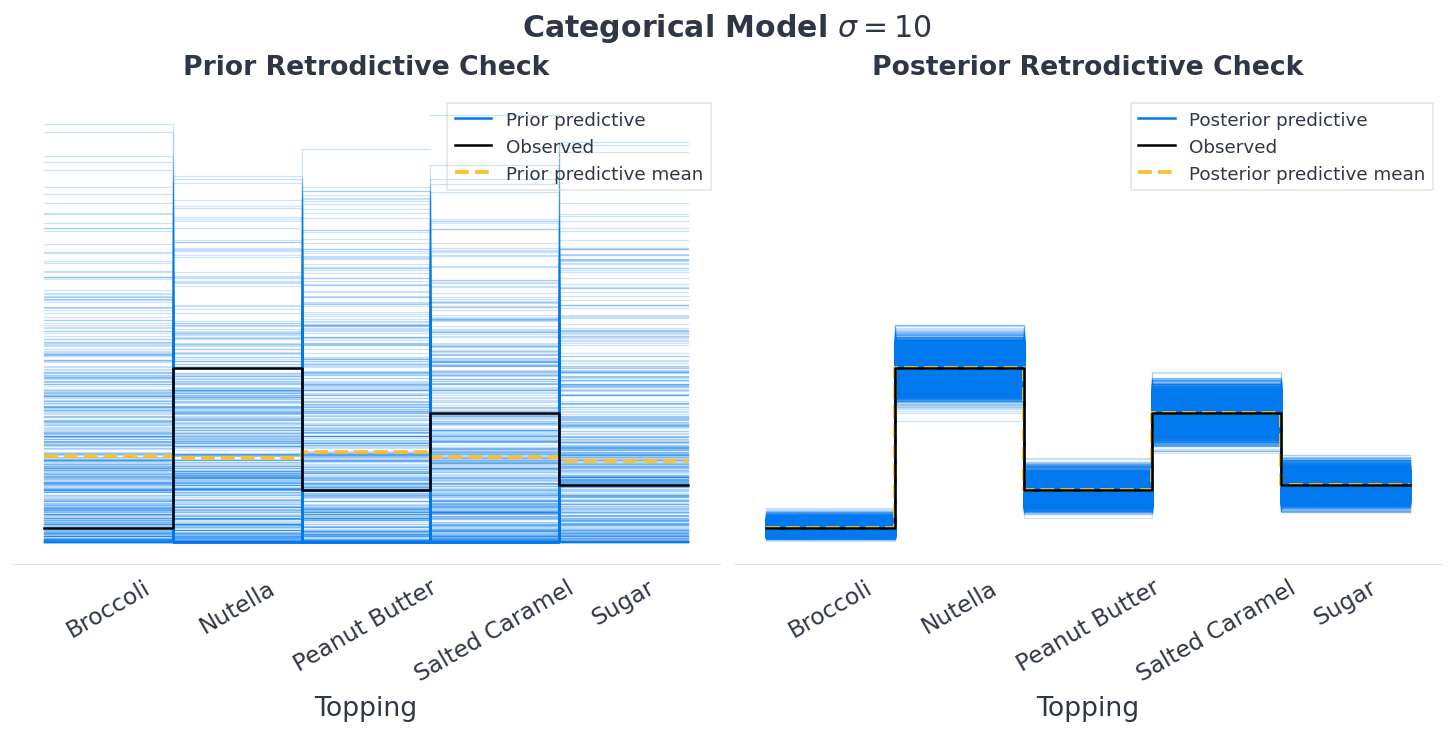

In [42]:
plot_forward_samples(large_cat_idata, targets=toppings, title=fr"Categorical Model $\sigma={scales[2]}$")

### Bambi
* Brocoli- reference class
* no intercept to avoid overparameterization
    * nationality is a categorical predictor
* if we add an intercept - Bambi is using a reference encoding (pivot) under the hood over the categorical covariate
    * French- pivot value (reference point)

In [43]:
bmb_cat_model = bmb.Model(
    formula="winning_topping ~ 0 + age + nationality",
    data=individual_answers,
    family="categorical",
    link="softmax"
)
print(bmb_cat_model)

       Formula: winning_topping ~ 0 + age + nationality
        Family: categorical
          Link: p = softmax
  Observations: 500
        Priors: 
    target = p
        Common-level effects
            age ~ Normal(mu: 0.0, sigma: 2.4993)
            nationality ~ Normal(mu: [0. 0. 0. 0.], sigma: [5.3866 6.2736 5.5323 6.2268])


In [44]:
# mcmc sampling
bmb_cat_idata = bmb_cat_model.fit(chains=4, random_seed=1234)
# prior predictive sampling
bmb_cat_idata.extend(bmb_cat_model.prior_predictive())
# posterior predictive sampling
bmb_cat_model.predict(bmb_cat_idata, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [age, nationality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
Sampling: [age, nationality, winning_topping]


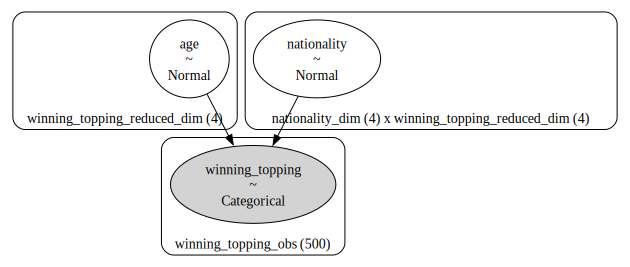

In [51]:
bmb_cat_model.graph()

In [53]:
az.summary(bmb_cat_idata, var_names=["age", "nationality"])

mean     sd  hdi_3%  hdi_97%  \
age[Nutella]                         -0.891  0.277  -1.441   -0.398   
age[Peanut Butter]                   -0.349  0.290  -0.889    0.192   
age[Salted Caramel]                  -1.198  0.284  -1.690   -0.614   
age[Sugar]                           -1.397  0.299  -1.976   -0.855   
nationality[Nutella, French]          3.365  0.612   2.221    4.486   
nationality[Nutella, German]          1.177  0.406   0.448    1.967   
nationality[Nutella, Italian]         4.681  0.925   3.086    6.439   
nationality[Nutella, Other]           3.521  0.723   2.229    4.894   
nationality[Peanut Butter, French]    1.606  0.670   0.373    2.837   
nationality[Peanut Butter, German]    0.878  0.418   0.130    1.673   
nationality[Peanut Butter, Italian]   2.736  0.956   1.031    4.541   
nationality[Peanut Butter, Other]     2.241  0.753   0.895    3.720   
nationality[Salted Caramel, French]   3.578  0.615   2.524    4.799   
nationality[Salted Caramel, German]   1.097  0.410   0.309    1.844   
nationality[Salted Caramel, Italian]  3.925  0.933   2.315    5.728   
nationality[Salted Caramel, Other]    2.533  0.748   1.204    3.964   
nationality[Sugar, French]            1.862  0.662   0.700    3.144   
nationality[Sugar, German]            0.720  0.431  -0.061    1.538   
nationality[Sugar, Italian]           3.243  0.946   1.552    5.008   
nationality[Sugar, Other]             2.141  0.759   0.744    3.580   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
age[Nutella]                              0.007    0.005    1817.0    1957.0   
age[Peanut Butter]                        0.007    0.005    1910.0    2162.0   
age[Salted Caramel]                       0.006    0.005    1967.0    1949.0   
age[Sugar]                                0.007    0.005    2055.0    1948.0   
nationality[Nutella, French]              0.014    0.010    2075.0    2146.0   
nationality[Nutella, German]              0.009    0.006    2209.0    2665.0   
nationality[Nutella, Italian]             0.021    0.016    2029.0    1645.0   
nationality[Nutella, Other]               0.015    0.011    2401.0    2237.0   
nationality[Peanut Butter, French]        0.014    0.011    2406.0    2273.0   
nationality[Peanut Butter, German]        0.009    0.007    2145.0    2716.0   
nationality[Peanut Butter, Italian]       0.022    0.017    2095.0    1700.0   
nationality[Peanut Butter, Other]         0.016    0.012    2467.0    2473.0   
nationality[Salted Caramel, French]       0.013    0.010    2196.0    2185.0   
nationality[Salted Caramel, German]       0.008    0.006    2523.0    2728.0   
nationality[Salted Caramel, Italian]      0.021    0.016    2047.0    1574.0   
nationality[Salted Caramel, Other]        0.015    0.012    2509.0    2258.0   
nationality[Sugar, French]                0.014    0.011    2256.0    2070.0   
nationality[Sugar, German]                0.009    0.006    2464.0    2672.0   
nationality[Sugar, Italian]               0.022    0.016    2047.0    1703.0   
nationality[Sugar, Other]                 0.016    0.012    2443.0    2633.0   

                                      r_hat  
age[Nutella]                            1.0  
age[Peanut Butter]                      1.0  
age[Salted Caramel]                     1.0  
age[Sugar]                              1.0  
nationality[Nutella, French]            1.0  
nationality[Nutella, German]            1.0  
nationality[Nutella, Italian]           1.0  
nationality[Nutella, Other]             1.0  
nationality[Peanut Butter, French]      1.0  
nationality[Peanut Butter, German]      1.0  
nationality[Peanut Butter, Italian]     1.0  
nationality[Peanut Butter, Other]       1.0  
nationality[Salted Caramel, French]     1.0  
nationality[Salted Caramel, German]     1.0  
nationality[Salted Caramel, Italian]    1.0  
nationality[Salted Caramel, Other]      1.0  
nationality[Sugar, French]              1.0  
nationality[Sugar, German]            

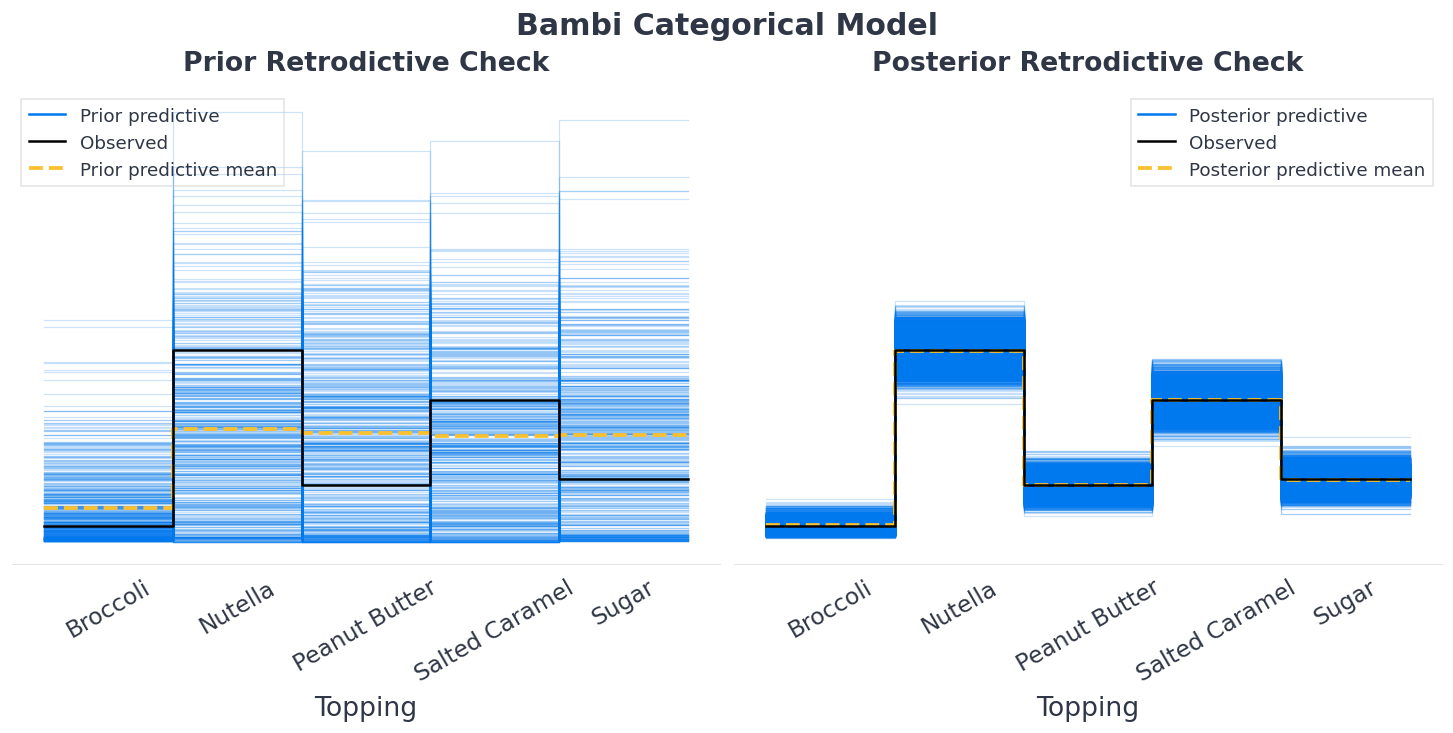

In [52]:
plot_forward_samples(bmb_cat_idata, targets=toppings, title="Bambi Categorical Model")

In [54]:
# Pivoting/Reference Encoding for nationality
bmb_pivot_model = bmb.Model(
    formula="winning_topping ~ 1 + age + nationality",
    data=individual_answers,
    family="categorical",
    link="softmax"
)
print(bmb_pivot_model)

       Formula: winning_topping ~ 1 + age + nationality
        Family: categorical
          Link: p = softmax
  Observations: 500
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.4486)
            age ~ Normal(mu: 0.0, sigma: 2.4993)
            nationality ~ Normal(mu: [0. 0. 0.], sigma: [6.2736 5.5323 6.2268])


In [55]:
# mcmc sampling
bmb_pivot_idata = bmb_pivot_model.fit(chains=4, random_seed=1234)
# prior predictive sampling
bmb_pivot_idata.extend(bmb_pivot_model.prior_predictive())
# posterior predictive sampling
bmb_pivot_model.predict(bmb_pivot_idata, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, age, nationality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 116 seconds.
Sampling: [Intercept, age, nationality, winning_topping]


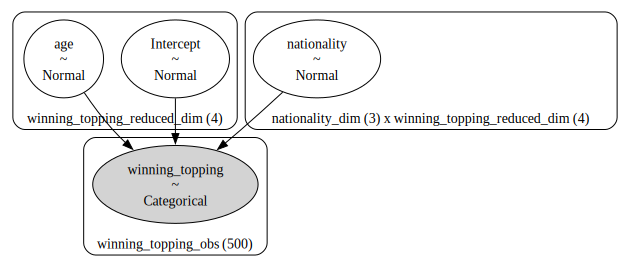

In [56]:
# French people as reference category
bmb_pivot_model.graph()

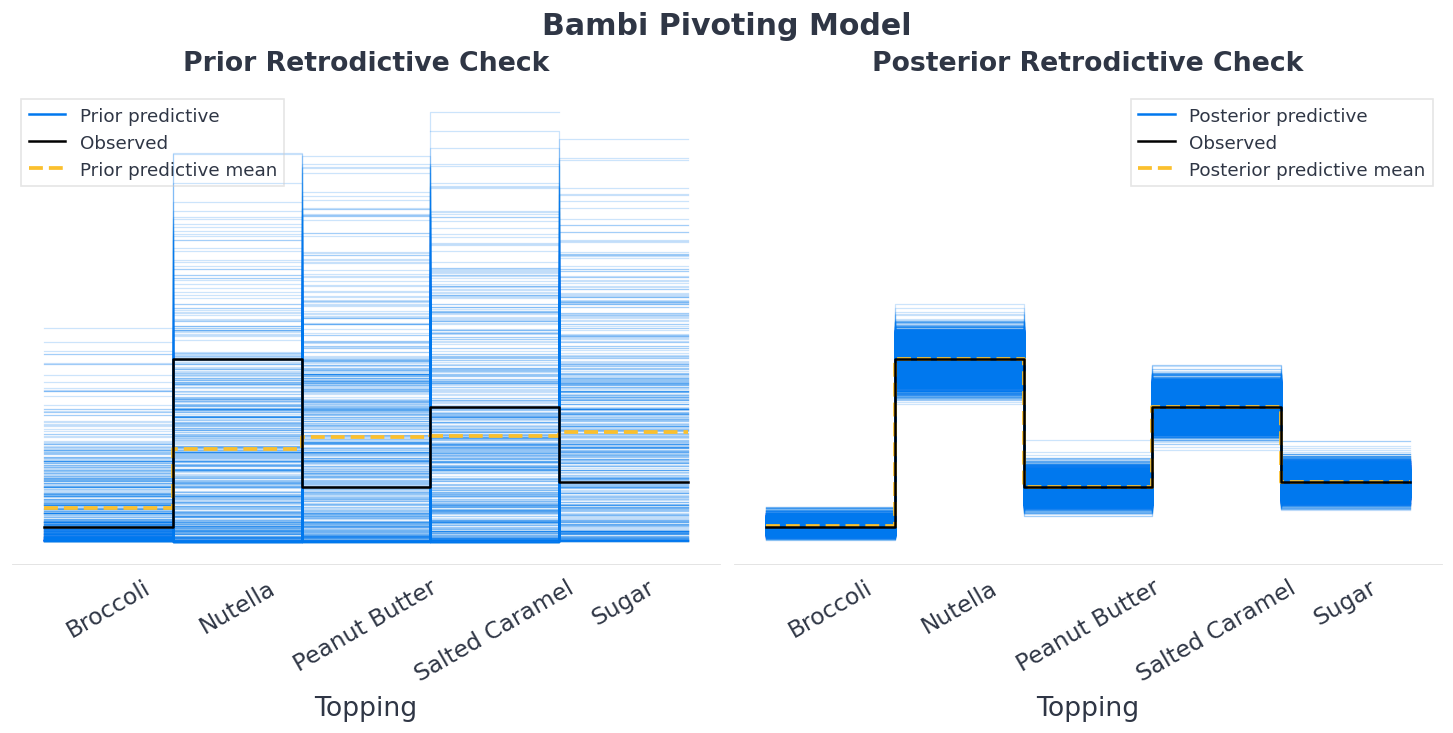

In [57]:
plot_forward_samples(bmb_pivot_idata, targets=toppings, title="Bambi Pivoting Model")

In [59]:
az.summary(bmb_pivot_idata, var_names=["Intercept", "age", "nationality"])

mean     sd  hdi_3%  hdi_97%  \
Intercept[Nutella]                    3.384  0.617   2.285    4.599   
Intercept[Peanut Butter]              1.627  0.662   0.408    2.893   
Intercept[Salted Caramel]             3.591  0.613   2.534    4.849   
Intercept[Sugar]                      1.889  0.654   0.667    3.111   
age[Nutella]                         -0.912  0.295  -1.485   -0.385   
age[Peanut Butter]                   -0.370  0.307  -1.009    0.146   
age[Salted Caramel]                  -1.218  0.300  -1.825   -0.688   
age[Sugar]                           -1.414  0.315  -1.975   -0.781   
nationality[Nutella, German]         -2.178  0.687  -3.423   -0.832   
nationality[Nutella, Italian]         1.352  1.052  -0.587    3.421   
nationality[Nutella, Other]           0.200  0.904  -1.488    1.915   
nationality[Peanut Butter, German]   -0.724  0.728  -2.075    0.654   
nationality[Peanut Butter, Italian]   1.177  1.095  -0.842    3.218   
nationality[Peanut Butter, Other]     0.677  0.958  -1.150    2.459   
nationality[Salted Caramel, German]  -2.463  0.680  -3.808   -1.209   
nationality[Salted Caramel, Italian]  0.394  1.062  -1.545    2.506   
nationality[Salted Caramel, Other]   -0.993  0.919  -2.713    0.742   
nationality[Sugar, German]           -1.133  0.742  -2.466    0.255   
nationality[Sugar, Italian]           1.416  1.096  -0.648    3.386   
nationality[Sugar, Other]             0.324  0.963  -1.498    2.109   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept[Nutella]                        0.016    0.011    1615.0    1731.0   
Intercept[Peanut Butter]                  0.016    0.012    1784.0    1827.0   
Intercept[Salted Caramel]                 0.015    0.011    1656.0    1766.0   
Intercept[Sugar]                          0.016    0.012    1770.0    1724.0   
age[Nutella]                              0.006    0.005    2061.0    2434.0   
age[Peanut Butter]                        0.006    0.005    2263.0    2649.0   
age[Salted Caramel]                       0.007    0.005    2030.0    2418.0   
age[Sugar]                                0.007    0.005    2092.0    2685.0   
nationality[Nutella, German]              0.017    0.012    1732.0    1694.0   
nationality[Nutella, Italian]             0.027    0.020    1482.0    1644.0   
nationality[Nutella, Other]               0.020    0.014    1987.0    2310.0   
nationality[Peanut Butter, German]        0.017    0.013    1855.0    2228.0   
nationality[Peanut Butter, Italian]       0.028    0.021    1579.0    1654.0   
nationality[Peanut Butter, Other]         0.020    0.014    2196.0    2605.0   
nationality[Salted Caramel, German]       0.016    0.012    1777.0    2007.0   
nationality[Salted Caramel, Italian]      0.027    0.020    1590.0    1632.0   
nationality[Salted Caramel, Other]        0.020    0.015    2024.0    2442.0   
nationality[Sugar, German]                0.017    0.013    1859.0    2069.0   
nationality[Sugar, Italian]               0.028    0.021    1538.0    1671.0   
nationality[Sugar, Other]                 0.021    0.015    2112.0    2667.0   

                                      r_hat  
Intercept[Nutella]                      1.0  
Intercept[Peanut Butter]                1.0  
Intercept[Salted Caramel]               1.0  
Intercept[Sugar]                        1.0  
age[Nutella]                            1.0  
age[Peanut Butter]                      1.0  
age[Salted Caramel]                     1.0  
age[Sugar]                              1.0  
nationality[Nutella, German]            1.0  
nationality[Nutella, Italian]           1.0  
nationality[Nutella, Other]             1.0  
nationality[Peanut Butter, German]      1.0  
nationality[Peanut Butter, Italian]     1.0  
nationality[Peanut Butter, Other]       1.0  
nationality[Salted Caramel, German]     1.0  
nationality[Salted Caramel, Italian]    1.0  
nationality[Salted Caramel, Other]      1.0  
nationality[Sugar, German]            

### PyMC Pivoting
* 'Brocolli' is the pivot class
* 
$X \beta_{\text{Brocolli}} = 0$

In [60]:
toppings[0], toppings[1:]

('Broccoli',
 Index(['Nutella', 'Peanut Butter', 'Salted Caramel', 'Sugar'], dtype='object'))

In [61]:
topping_pivot_coords = {
    "toppings_reduced": toppings[1:],
    "obs_idx": individual_answers.index,
    "nationality": nationalities,
}

In [62]:
with pm.Model(coords=topping_pivot_coords) as pivot_model:
    # data containers
    age = pm.MutableData("age", individual_answers["age"], dims="obs_idx")
    nationality_id = pm.MutableData(
        "nationality_id", individual_answers["nationality_idx"], dims="obs_idx"
    )
    winning_topping = pm.MutableData(
        "winning_topping", individual_answers["winning_topping_idx"], dims="obs_idx"
    )

    # coefficients for each (nationality, topping) except from broccoli
    β_nationality = pm.Normal(
        "β_nationality", sigma=6, dims=("nationality", "toppings_reduced")
    )
    # coefficients on age for each topping except from broccoli
    β_age = pm.Normal("β_age", sigma=2.5, dims="toppings_reduced")

    # pivot- first class (e.g., broccoli) is the pivot (Xβ=0)
    pivot_category = pyt.zeros((len(individual_answers), 1))
    
    # regression
    # dims=("obs_idx", "toppings_reduced")
    η_reduced = β_nationality[nationality_id] + age[:, None] @ β_age[None, :]
    
    # plug pivot
    # pt.concatenate([np.zeros((observed.shape[0], 1)), eta], axis=1)
    # dims=("obs_idx", "toppings")
    η = pyt.concatenate(
        [pivot_category, η_reduced],
        axis=-1
    )

    # convert to probabilities
    # dims=("obs_idx", "toppings")
    p = pm.math.softmax(η, axis=-1)
    
    print(f"η reduced shape: {η_reduced.eval().shape}")
    print(f"η shape: {η.eval().shape}")
    print(f"probs. shape = {p.eval().shape}")
    assert np.allclose(p.eval().sum(axis=1), np.ones(len(individual_answers))), "probabilities don't sum to 1"
    
    # likelihood
    _ = pm.Categorical("y", p=p, observed=winning_topping, dims="obs_idx")

η reduced shape: (500, 4)
η shape: (500, 5)
probs. shape = (500, 5)


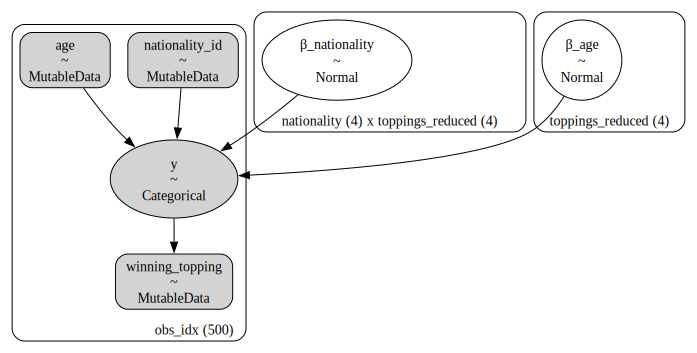

In [63]:
pm.model_to_graphviz(pivot_model)

In [64]:
with pivot_model:
    pivot_idata = pm.sample(chains=4, random_seed=1234)
    pivot_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(pivot_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β_nationality, β_age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
Sampling: [y, β_age, β_nationality]
Sampling: [y]


In [65]:
az.summary(pivot_idata, var_names="β_age")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
β_age[Nutella]        -0.900  0.284  -1.415   -0.375      0.007    0.005   
β_age[Peanut Butter]  -0.356  0.300  -0.901    0.189      0.007    0.005   
β_age[Salted Caramel] -1.204  0.291  -1.726   -0.660      0.007    0.005   
β_age[Sugar]          -1.405  0.305  -1.963   -0.833      0.007    0.005   

                       ess_bulk  ess_tail  r_hat  
β_age[Nutella]           1728.0    2315.0    1.0  
β_age[Peanut Butter]     2004.0    2493.0    1.0  
β_age[Salted Caramel]    1850.0    2406.0    1.0  
β_age[Sugar]             1859.0    2483.0    1.0

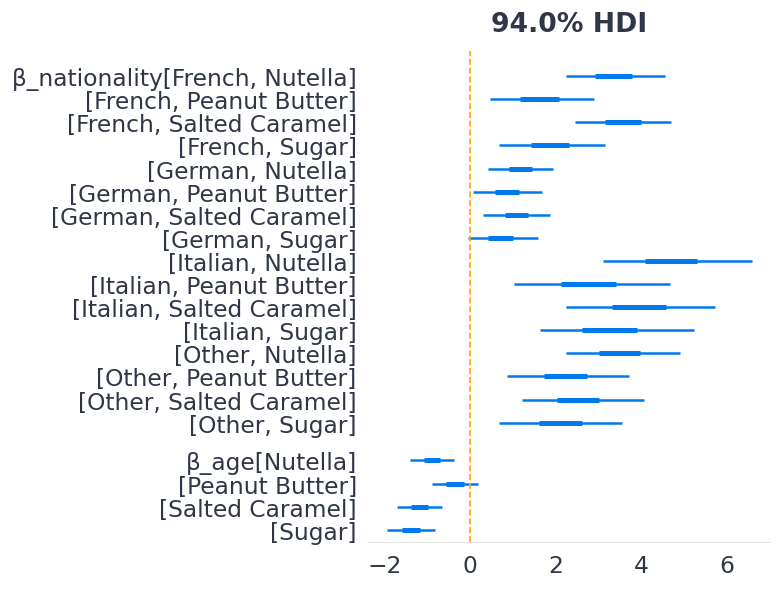

In [71]:
fig, ax = plt.subplots(layout="constrained")
az.plot_forest(pivot_idata, combined=True, ax=ax)
ax.axvline(x=0, color="orange", lw=1, ls="--")
plt.show()

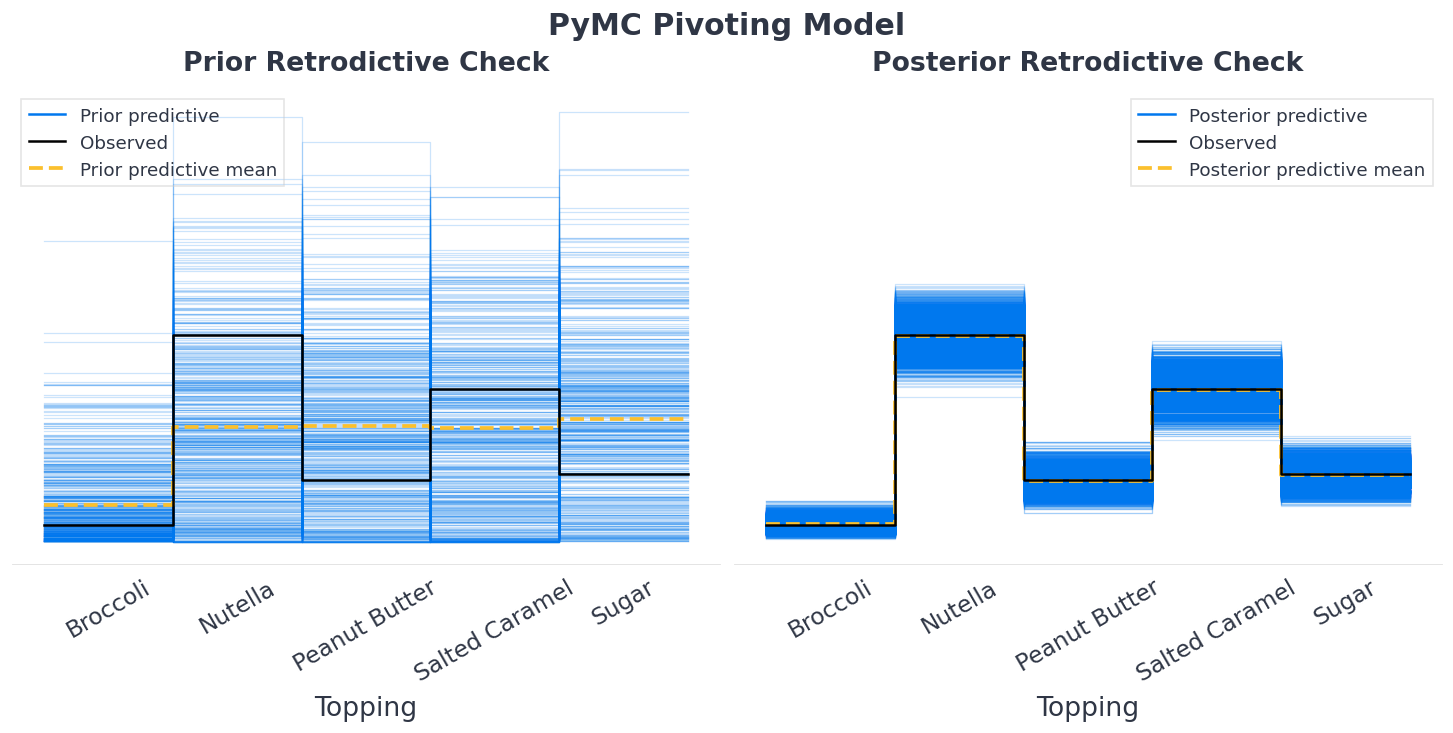

In [72]:
plot_forward_samples(pivot_idata, targets=toppings, title="PyMC Pivoting Model")

## Overparametrization

* if we removed the zero-sum constraint on nationalities, we in fact added a second intercept for each topping. 
    * `intercepts` and `β_nationality` are trying to estimate the same quantity. 2 parameters, 1 quantity of interest.

* In the plot below, we basically have **two intercepts for each topping**, so the model can infer the _sum_ of `intercepts` and `β_nationality`, but not the _individual_ elements -- over-parametrization everyone!

* This undetermination is **made even worse by our wide priors**.

* **solution**- constrain `β_nationality` to sum to zero _also_ across nationalities.\
That way, `intercepts` really catches the baseline popularity for each topping, and `β_nationality` represents, for any given topping, the deviation from this popularity for each nationality -- no confusion of parameters any more!

In [74]:
with pm.Model(coords=toppings_coords) as categorical_zsm_model:
    # data containers
    age = pm.MutableData("age", individual_answers["age"], dims="obs_idx")
    nationalities_id = pm.MutableData(
        "nationalities_id", individual_answers["nationality_idx"], dims="obs_idx"
    )  # categorical value (index)
    winning_topping = pm.MutableData(
        "winning_topping", individual_answers["winning_topping_idx"], dims="obs_idx"
    )

    ##### parameters #####
    # intercept for each class (topping)
    intercepts = pm.ZeroSumNormal("intercepts", sigma=5, dims="toppings")  
    # (age) slope for each class
    β_age = pm.ZeroSumNormal("β_age", sigma=1, dims="toppings")  
    # offset for each nationality (for each topping). Apply zerosum constraint on both axes (nationality and toppings)
    β_nationality = pm.ZeroSumNormal(
        "β_nationality", sigma=1, dims=("nationality", "toppings")
    )

    # linear regression
    # dims=("obs_idx", "toppings")
    p = pm.math.softmax(
        intercepts[None] + β_nationality[nationalities_id] + pyt.outer(age, β_age),
        axis=-1,
    )
    assert np.allclose(p.eval().sum(axis=1), np.ones(len(individual_answers))), "probabilities don't sum to 1"
    
    # likelihood
    _ = pm.Categorical("y", p=p, observed=winning_topping, dims="obs_idx")

In [75]:
with categorical_zsm_model:
    categorical_zsm_idata = pm.sample(chains=4, random_seed=1234)
    categorical_zsm_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(categorical_zsm_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercepts, β_age, β_nationality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.
Sampling: [intercepts, y, β_age, β_nationality]
Sampling: [y]


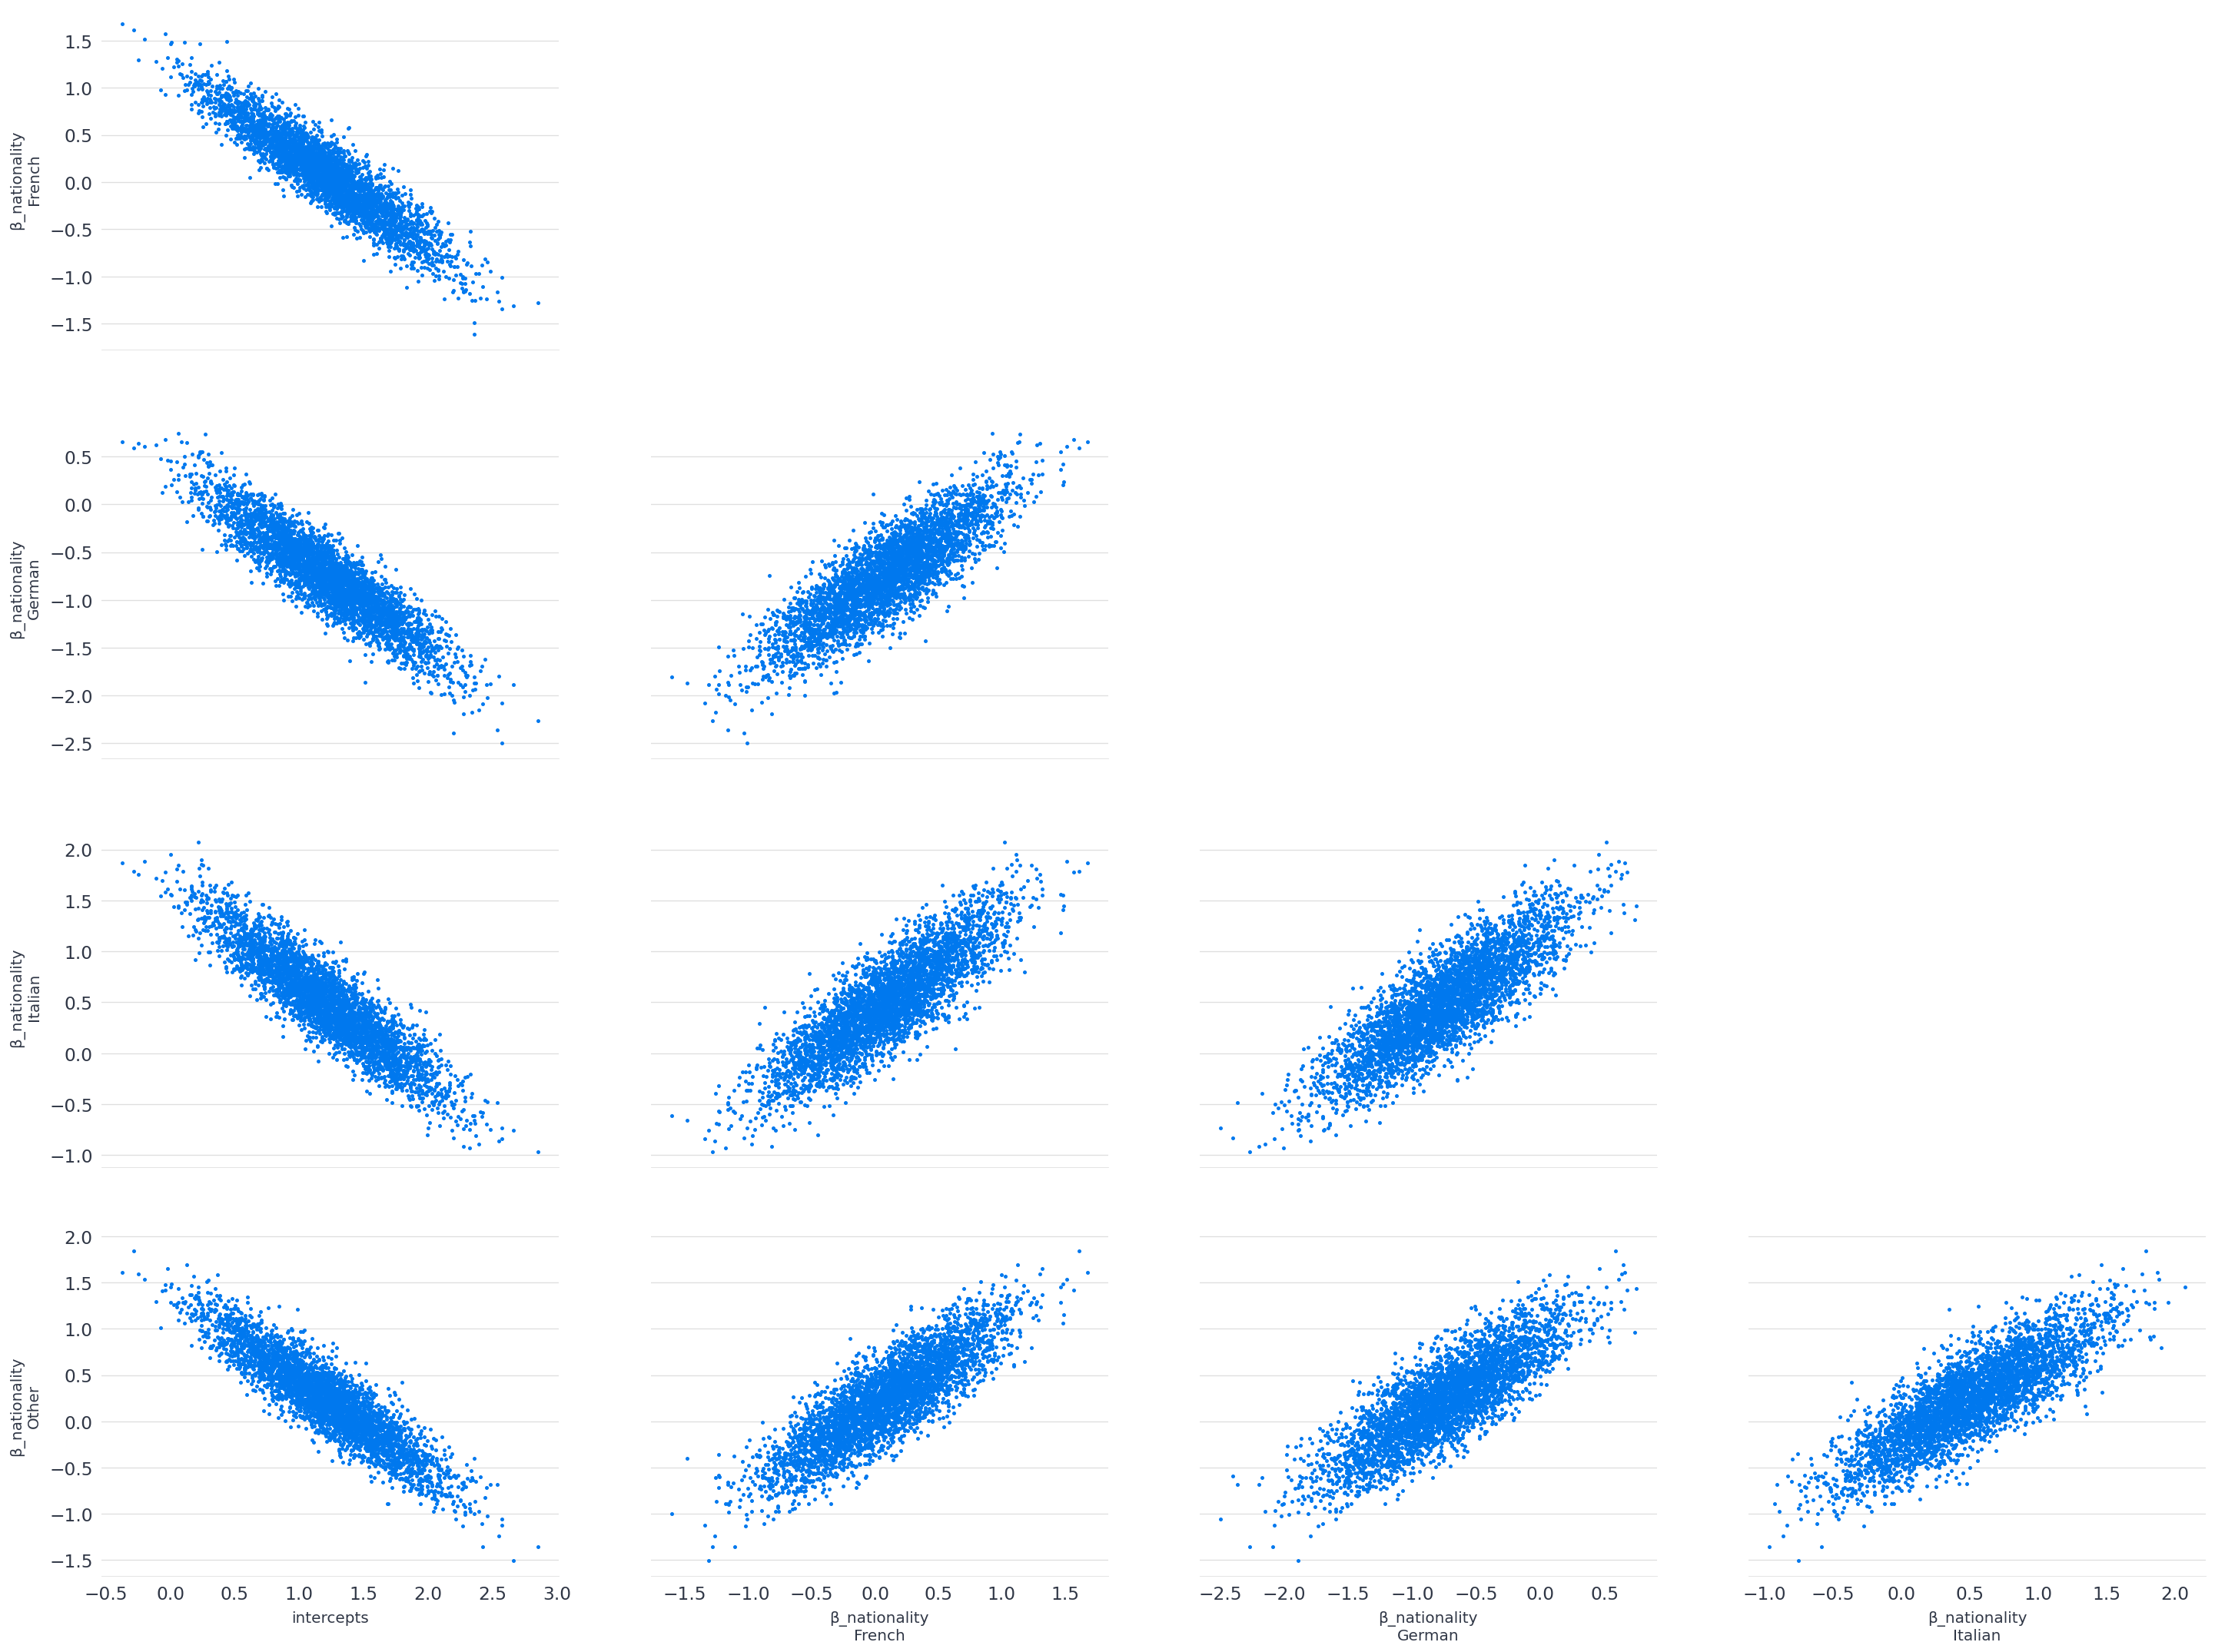

In [76]:
az.plot_pair(
    categorical_zsm_idata,
    var_names=["intercepts", "β_nationality"],
    coords={"toppings": "Nutella"},
);

# Estonian dataset
* for each stratum find its intentional vote
* strata- (age_group, education, gender, nationality, electoral_district, unit)
    * unit- a sub-region in the electoral_district
* 11 different parties


In [4]:
estonian_df = pd.read_csv("../data/estonian-data.csv")
print(estonian_df.shape)
estonian_df.head(3)

(5206, 17)


age_group        education gender nationality  \
0     16-24  Basic education   Male    Estonian   
1     16-24  Basic education   Male    Estonian   
2     16-24  Basic education   Male    Estonian   

                      electoral_district       unit  EKRE  Eesti 200  \
0  Haabersti, Põhja-Tallinn ja Kristiine  Kristiine     0          0   
1                     Harju- ja Raplamaa   Harjumaa     0          0   
2                     Harju- ja Raplamaa   Harjumaa     0          0   

   Hard to say  Isamaa  Keskerakond  Mitte ükski erakond  Other  Parempoolsed  \
0            0       0            0                    1      0             0   
1            0       0            0                    0      0             0   
2            0       0            0                    0      0             0   

   Reformierakond  Rohelised  SDE  
0               0          0    0  
1               1          0    0  
2               0          0    1

In [5]:
PARTIES = estonian_df.columns[6:]
print(PARTIES.tolist())
# each stratum vote to a single party
estonian_df[PARTIES].sum(axis=1).describe()

['EKRE', 'Eesti 200', 'Hard to say', 'Isamaa', 'Keskerakond', 'Mitte ükski erakond', 'Other', 'Parempoolsed', 'Reformierakond', 'Rohelised', 'SDE']


count    5206.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In [6]:
party_idx = np.where(estonian_df[PARTIES] == 1)[1]
np.asarray(PARTIES)[party_idx]

array(['Mitte ükski erakond', 'Reformierakond', 'SDE', ..., 'Keskerakond',
       'Mitte ükski erakond', 'Hard to say'], dtype=object)

In [7]:
estonian_df["winning_party"] = np.asarray(PARTIES)[party_idx]

#### Bambi Modeling

In [33]:
estonian_bmb_model = bmb.Model(
    formula="winning_party ~ 0 + age_group + education + age_group:education + gender + nationality",
    data=estonian_df,
    family="categorical",
    link="softmax"
)
print(estonian_bmb_model)

       Formula: winning_party ~ 0 + age_group + education + age_group:education + gender + nationality
        Family: categorical
          Link: p = softmax
  Observations: 5206
        Priors: 
    target = p
        Common-level effects
            age_group ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0.], sigma: [8.8258 6.8225 6.5431 6.7415 6.7961 7.3371
                7.8461])
            education ~ Normal(mu: [0. 0.], sigma: [5.1662 5.0024])
            age_group:education ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma: [ 9.7541  9.816
                9.1698  9.5304 10.3484  8.8965 10.6946  8.5695 11.3538
              9.6108 13.2648 10.2028])
            gender ~ Normal(mu: 0.0, sigma: 5.0217)
            nationality ~ Normal(mu: 0.0, sigma: 6.1119)


In [9]:
estonian_bmb_idata = estonian_bmb_model.fit(chains=4, random_seed=1234)
estonian_bmb_idata.extend(estonian_bmb_model.prior_predictive())
estonian_bmb_model.predict(estonian_bmb_idata, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [age_group, education, age_group:education, gender, nationality]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7996 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [age_group, age_group:education, education, gender, nationality, winning_party]


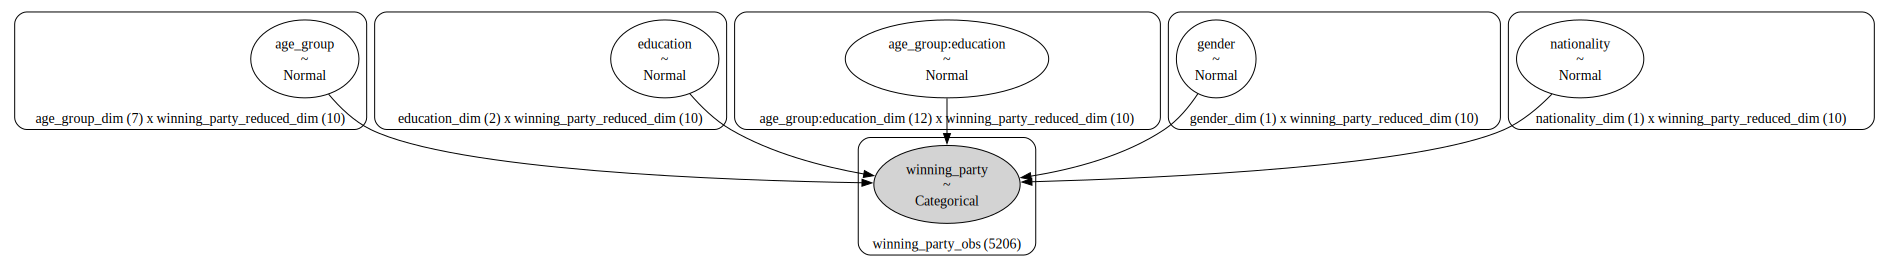

In [10]:
estonian_bmb_model.graph()

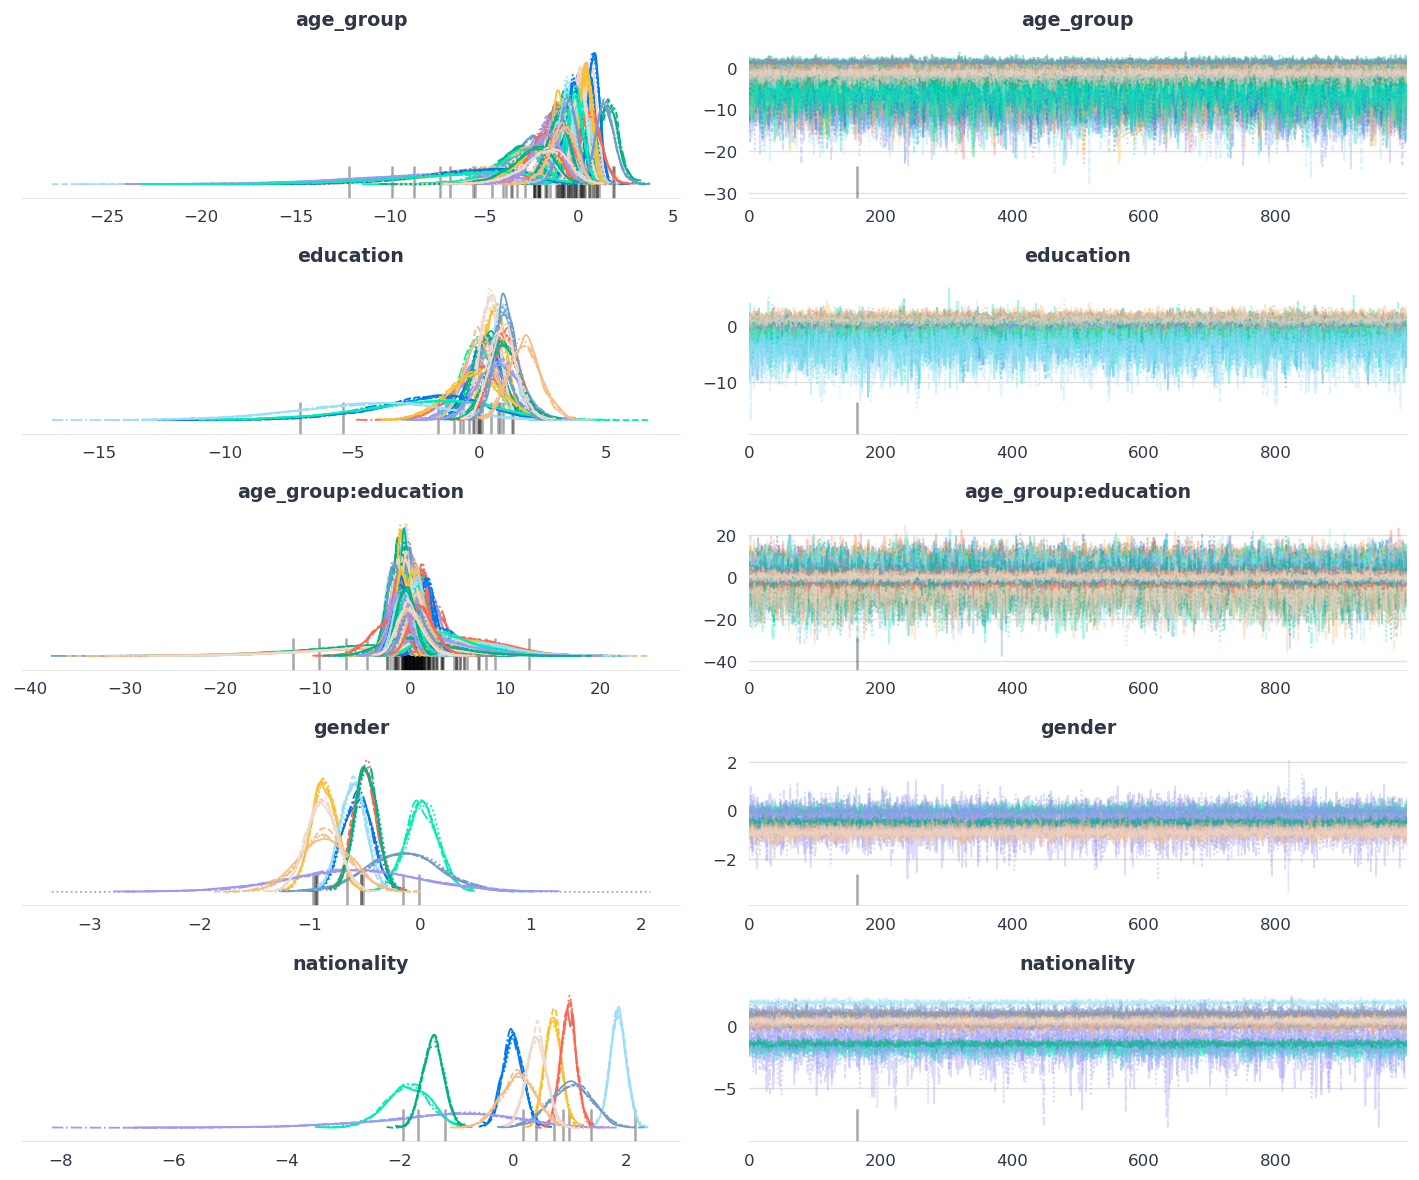

In [14]:
az.plot_trace(
    estonian_bmb_idata,
    var_names=["age_group", "education", "age_group:education", "gender", "nationality"]
)
plt.tight_layout()
plt.show()

In [15]:
# save inference data
az.to_netcdf(estonian_bmb_idata, "../models/estonian_bmb_idata.nc")

'../models/estonian_bmb_idata.nc'

#### PyMC modeling

In [8]:
age_group_idx, age_groups = estonian_df["age_group"].factorize(sort=True)

education_idx, education = estonian_df["education"].factorize(sort=True)

gender_idx, genders = estonian_df["gender"].factorize(sort=True)

nationality_idx, nationalities = estonian_df["nationality"].factorize(sort=True)

In [10]:
estonian_coords = {
    "age_groups": age_groups,
    "education": education,
    "genders": genders,
    "nationalities": nationalities,
    "obs_idx": estonian_df.index,
    "parties": PARTIES
}

In [11]:
with pm.Model(coords=estonian_coords) as estonian_pymc_model:
    # data
    age_group_id = pm.MutableData("age_group_id", age_group_idx, dims="obs_idx")
    nationality_id = pm.MutableData("nationality_id", nationality_idx, dims="obs_idx")
    education_id = pm.MutableData("education_id", education_idx, dims="obs_idx")  
    gender_id = pm.MutableData("gender_id", gender_idx, dims="obs_idx")
    observed = pm.MutableData("observed", party_idx, dims="obs_idx")

    ##### parameters #####

    # intercept for each class (topping)
    intercepts = pm.ZeroSumNormal("intercepts", dims="parties")
    # offset for each age_group (for each party) Apply zerosum constraint on both axes (age_group and parties)
    β_age_group = pm.ZeroSumNormal("β_age_group", dims=("age_groups", "parties"), zerosum_axes=2)
    # offset for each nationality (for each party)
    β_nationality = pm.ZeroSumNormal("β_nationality", dims=("nationalities", "parties"), zerosum_axes=2)
    # offset for each education level (for each party)
    β_education = pm.ZeroSumNormal(
        "β_education", dims=("education", "parties"), zerosum_axes=2
    )
    # offset for each gender (for each party)
    β_gender = pm.ZeroSumNormal(
        "β_gender", dims=("genders", "parties"), zerosum_axes=2
    )
    # offset for each interaction between age group and gender (for each party)
    β_age_education = pm.ZeroSumNormal(
        "β_age_education", dims=("age_groups", "education", "parties"), zerosum_axes=3
    )
    
    print(f"intercepts shape: {intercepts.eval().shape}")
    print(f"β_age_group offset shape: {β_age_group.eval().shape}")
    print(f"β_nationality offset shape: {β_nationality.eval().shape}")
    print(f"β_education offset shape: {β_education.eval().shape}")
    print(f"β_gender offset shape: {β_gender.eval().shape}")
    print(f"β_age_education offset shape: {β_age_education.eval().shape}")

    # linear regression
    # dims=("obs_idx", "parties")
    η = (
        intercepts[None] + β_age_group[age_group_id] + β_nationality[nationality_id] 
                         + β_education[education_id] + β_gender[gender_id]
                         + β_age_education[age_group_id, education_id])
    p = pm.math.softmax(
        η,
        axis=-1,
    )
    print(f"η shape = {η.eval().shape}")
    print(f"p shape = {p.eval().shape}")
    assert np.allclose(p.eval().sum(axis=1), np.ones(len(party_idx))), "probabilities don't sum to 1"
    # likelihood
    _ = pm.Categorical("y", p=p, observed=observed, dims="obs_idx")

intercepts shape: (11,)
β_age_group offset shape: (7, 11)
β_nationality offset shape: (2, 11)
β_education offset shape: (3, 11)
β_gender offset shape: (2, 11)
β_age_education offset shape: (7, 3, 11)
η shape = (5206, 11)
p shape = (5206, 11)


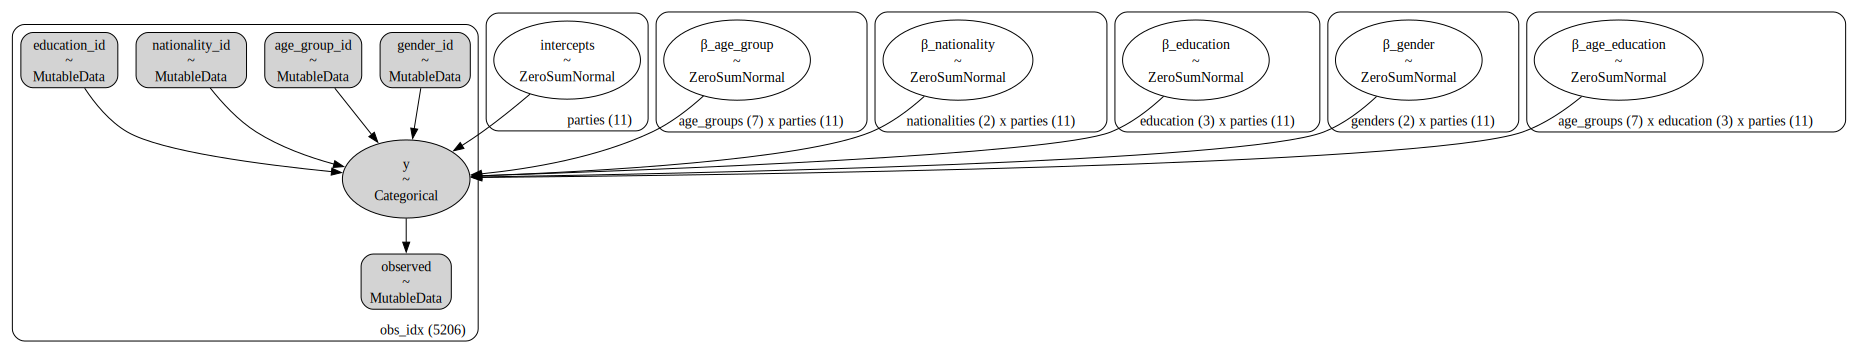

In [12]:
pm.model_to_graphviz(estonian_pymc_model)

In [13]:
with estonian_pymc_model:
    estonian_pymc_idata = pm.sample(chains=4, random_seed=1234)
    estonian_pymc_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(estonian_pymc_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercepts, β_age_group, β_nationality, β_education, β_gender, β_age_education]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1619 seconds.
Sampling: [intercepts, y, β_age_education, β_age_group, β_education, β_gender, β_nationality]
Sampling: [y]


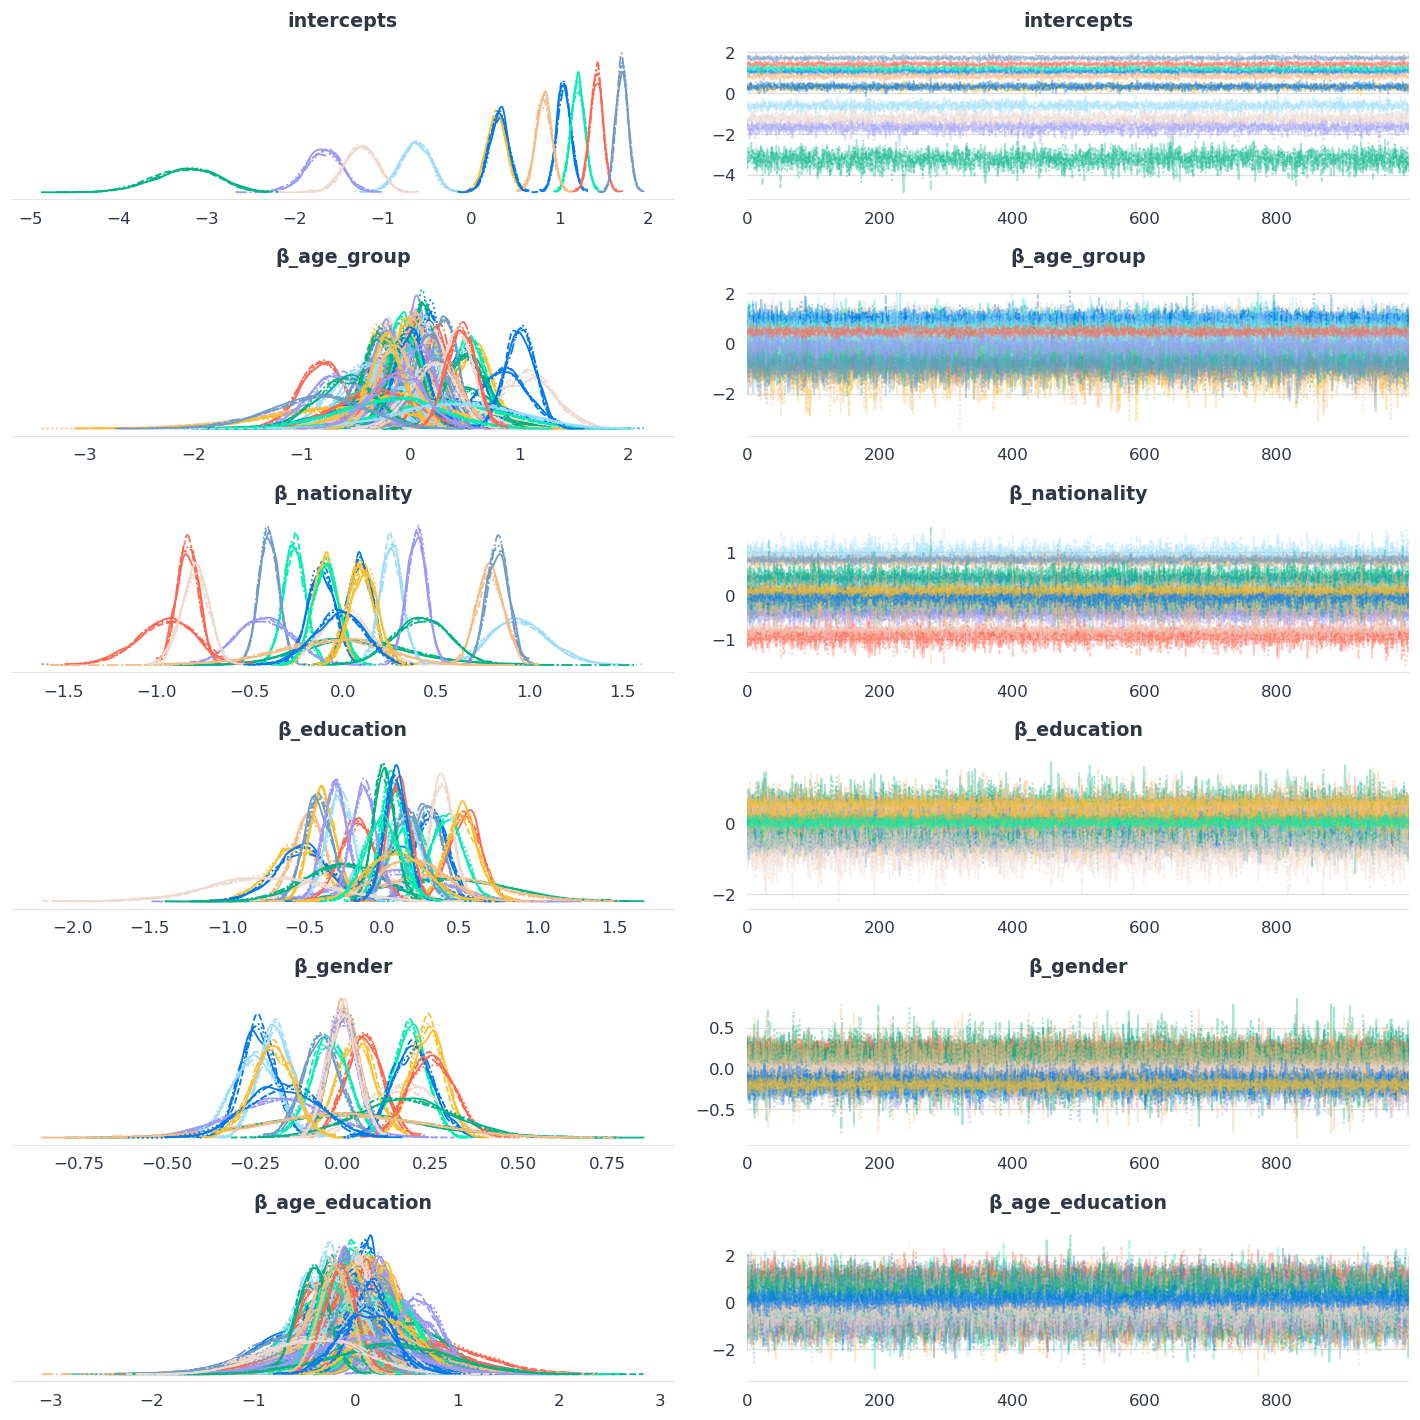

In [15]:
az.plot_trace(estonian_pymc_idata)
plt.tight_layout()
plt.show()

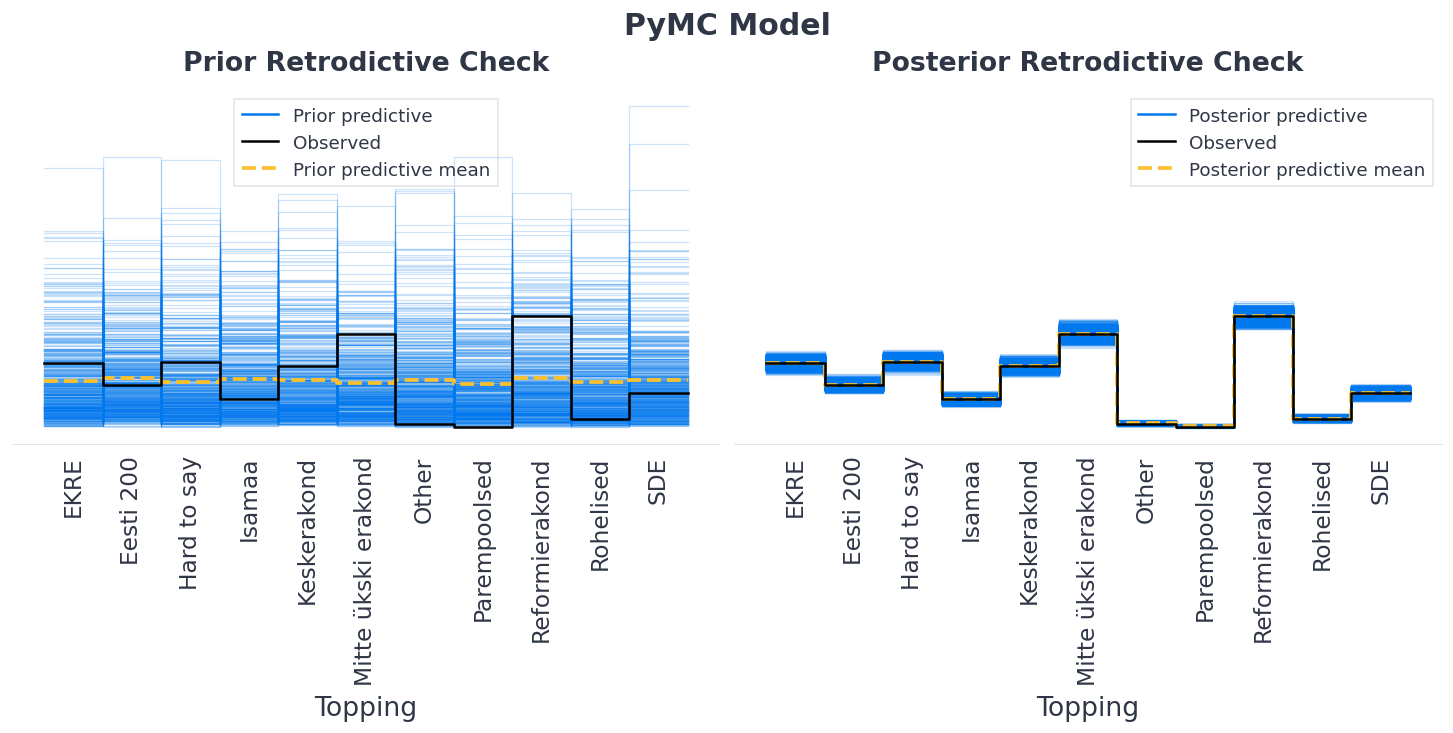

In [16]:
plot_forward_samples(estonian_pymc_idata, targets=PARTIES, title="PyMC Model", rotation=90)

In [17]:
estonian_bmb_idata = az.from_netcdf( "../models/estonian_bmb_idata.nc")

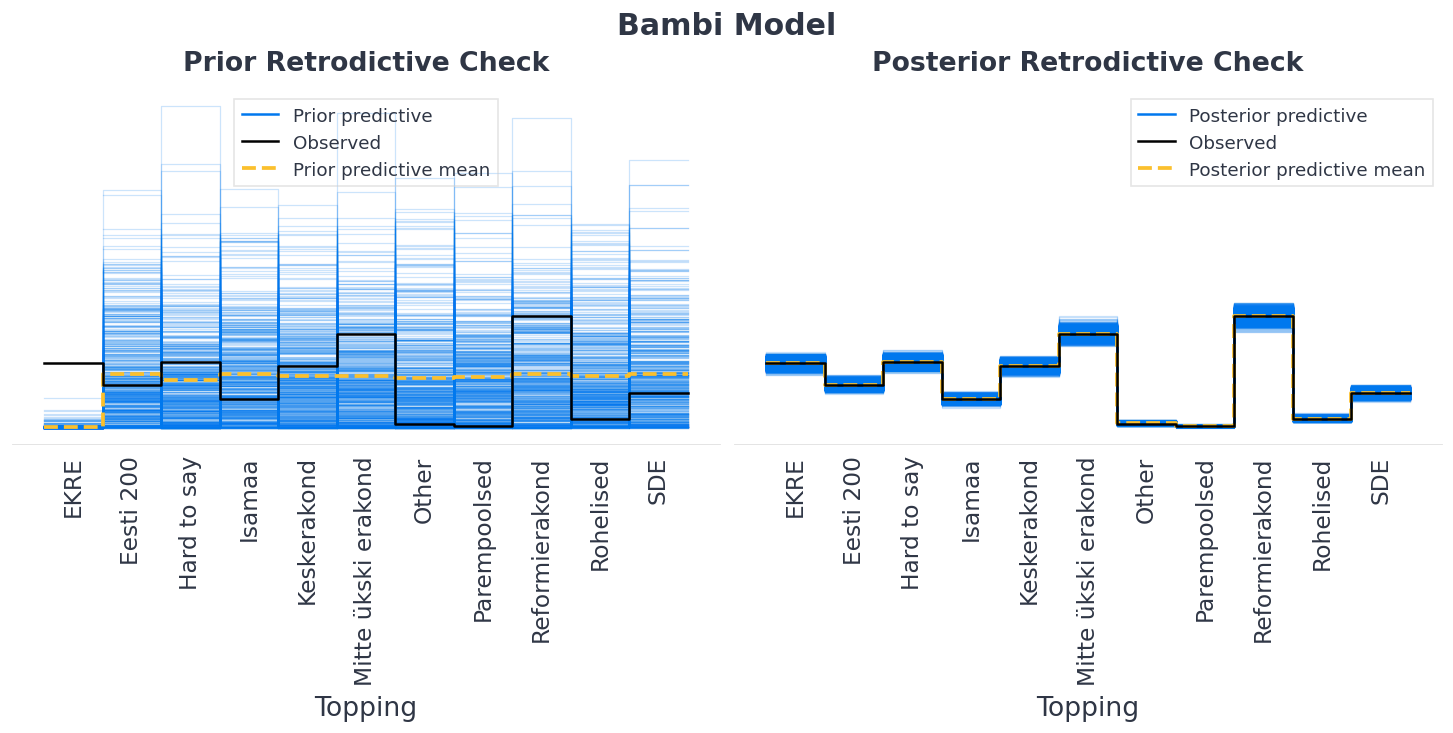

In [18]:
plot_forward_samples(estonian_bmb_idata, targets=PARTIES, title="Bambi Model", rotation=90)

### Sub-population Analysis
* voting preferences comparison between highly educated non-Estonian females with different age groups
    * 25-34 age group
    * 75+ age group


In [43]:
def plot_post_p(posterior: az.InferenceData, demographics: Dict[str, str], is_bmb: bool=False) -> Tuple[np.ndarray, xr.DataArray]:

    post_p = (
        compute_post_p(posterior,demographics) if not is_bmb 
        else compute_bmb_post_p(posterior,demographics)
    )
    axes = az.plot_posterior(post_p)
    for ax in axes.ravel():
        ax.set_title(ax.get_title().replace("mean_popularity", "Posterior Intention to Vote"))

    plt.tight_layout()

    return axes, post_p


def compute_post_p(
    posterior: az.InferenceData, demographics: Dict[str, str]
) -> xr.DataArray:
    return (
        xr.apply_ufunc(
            special.softmax,
            (
                posterior["intercepts"]
                + posterior["β_age_group"].sel(age_groups=demographics["age_groups"])
                + posterior["β_nationality"].sel(nationalities=demographics["nationalities"])
                + posterior["β_gender"].sel(genders=demographics["genders"])
                + posterior["β_education"].sel(education=demographics["education"])
                + (posterior["β_age_education"]
                       .sel(age_groups=demographics["age_groups"], 
                            education=demographics["education"])
                  )
            ),
            kwargs=dict(axis=-1),  # apply (softmax) on the last axis
        ).rename("mean_popularity")
        * 100  # return the percentage (instead of dist. over the classes) 
    )


def compute_bmb_post_p(
    posterior: az.InferenceData, demographics: Dict[str, str]
) -> xr.DataArray:
    return (
        xr.apply_ufunc(
            special.softmax,
            (
                + posterior["age_group"].sel(age_groups=demographics["age_group"])
                + posterior["nationality"].sel(nationalities=demographics["nationality"])
                + posterior["gender"].sel(genders=demographics["gender"])
                + posterior["education"].sel(education=demographics["education"])
                + (posterior["age_group:education"]
                       .sel(age_groups=demographics["age_group"], 
                            education=demographics["education"])
                  )
            ),
            kwargs=dict(axis=-1),  # apply (softmax) on the last axis
        ).rename("mean_popularity")
        * 100  # return the percentage (instead of dist. over the classes) 
    )

In [21]:
# make a prediction for a specific sub-population
compute_post_p(
    posterior=estonian_pymc_idata.posterior,
    demographics=dict(
        education="Higher education",
        nationalities="Other",
        genders="Female",
        age_groups="75+",
        
    )).mean(dim=("chain", "draw")).to_numpy()

array([ 5.44493995,  3.93601315, 10.07797638,  0.4889558 , 49.49448213,
       13.91382542,  0.7081607 ,  0.36739068,  4.91338124,  0.83455214,
        9.82032239])

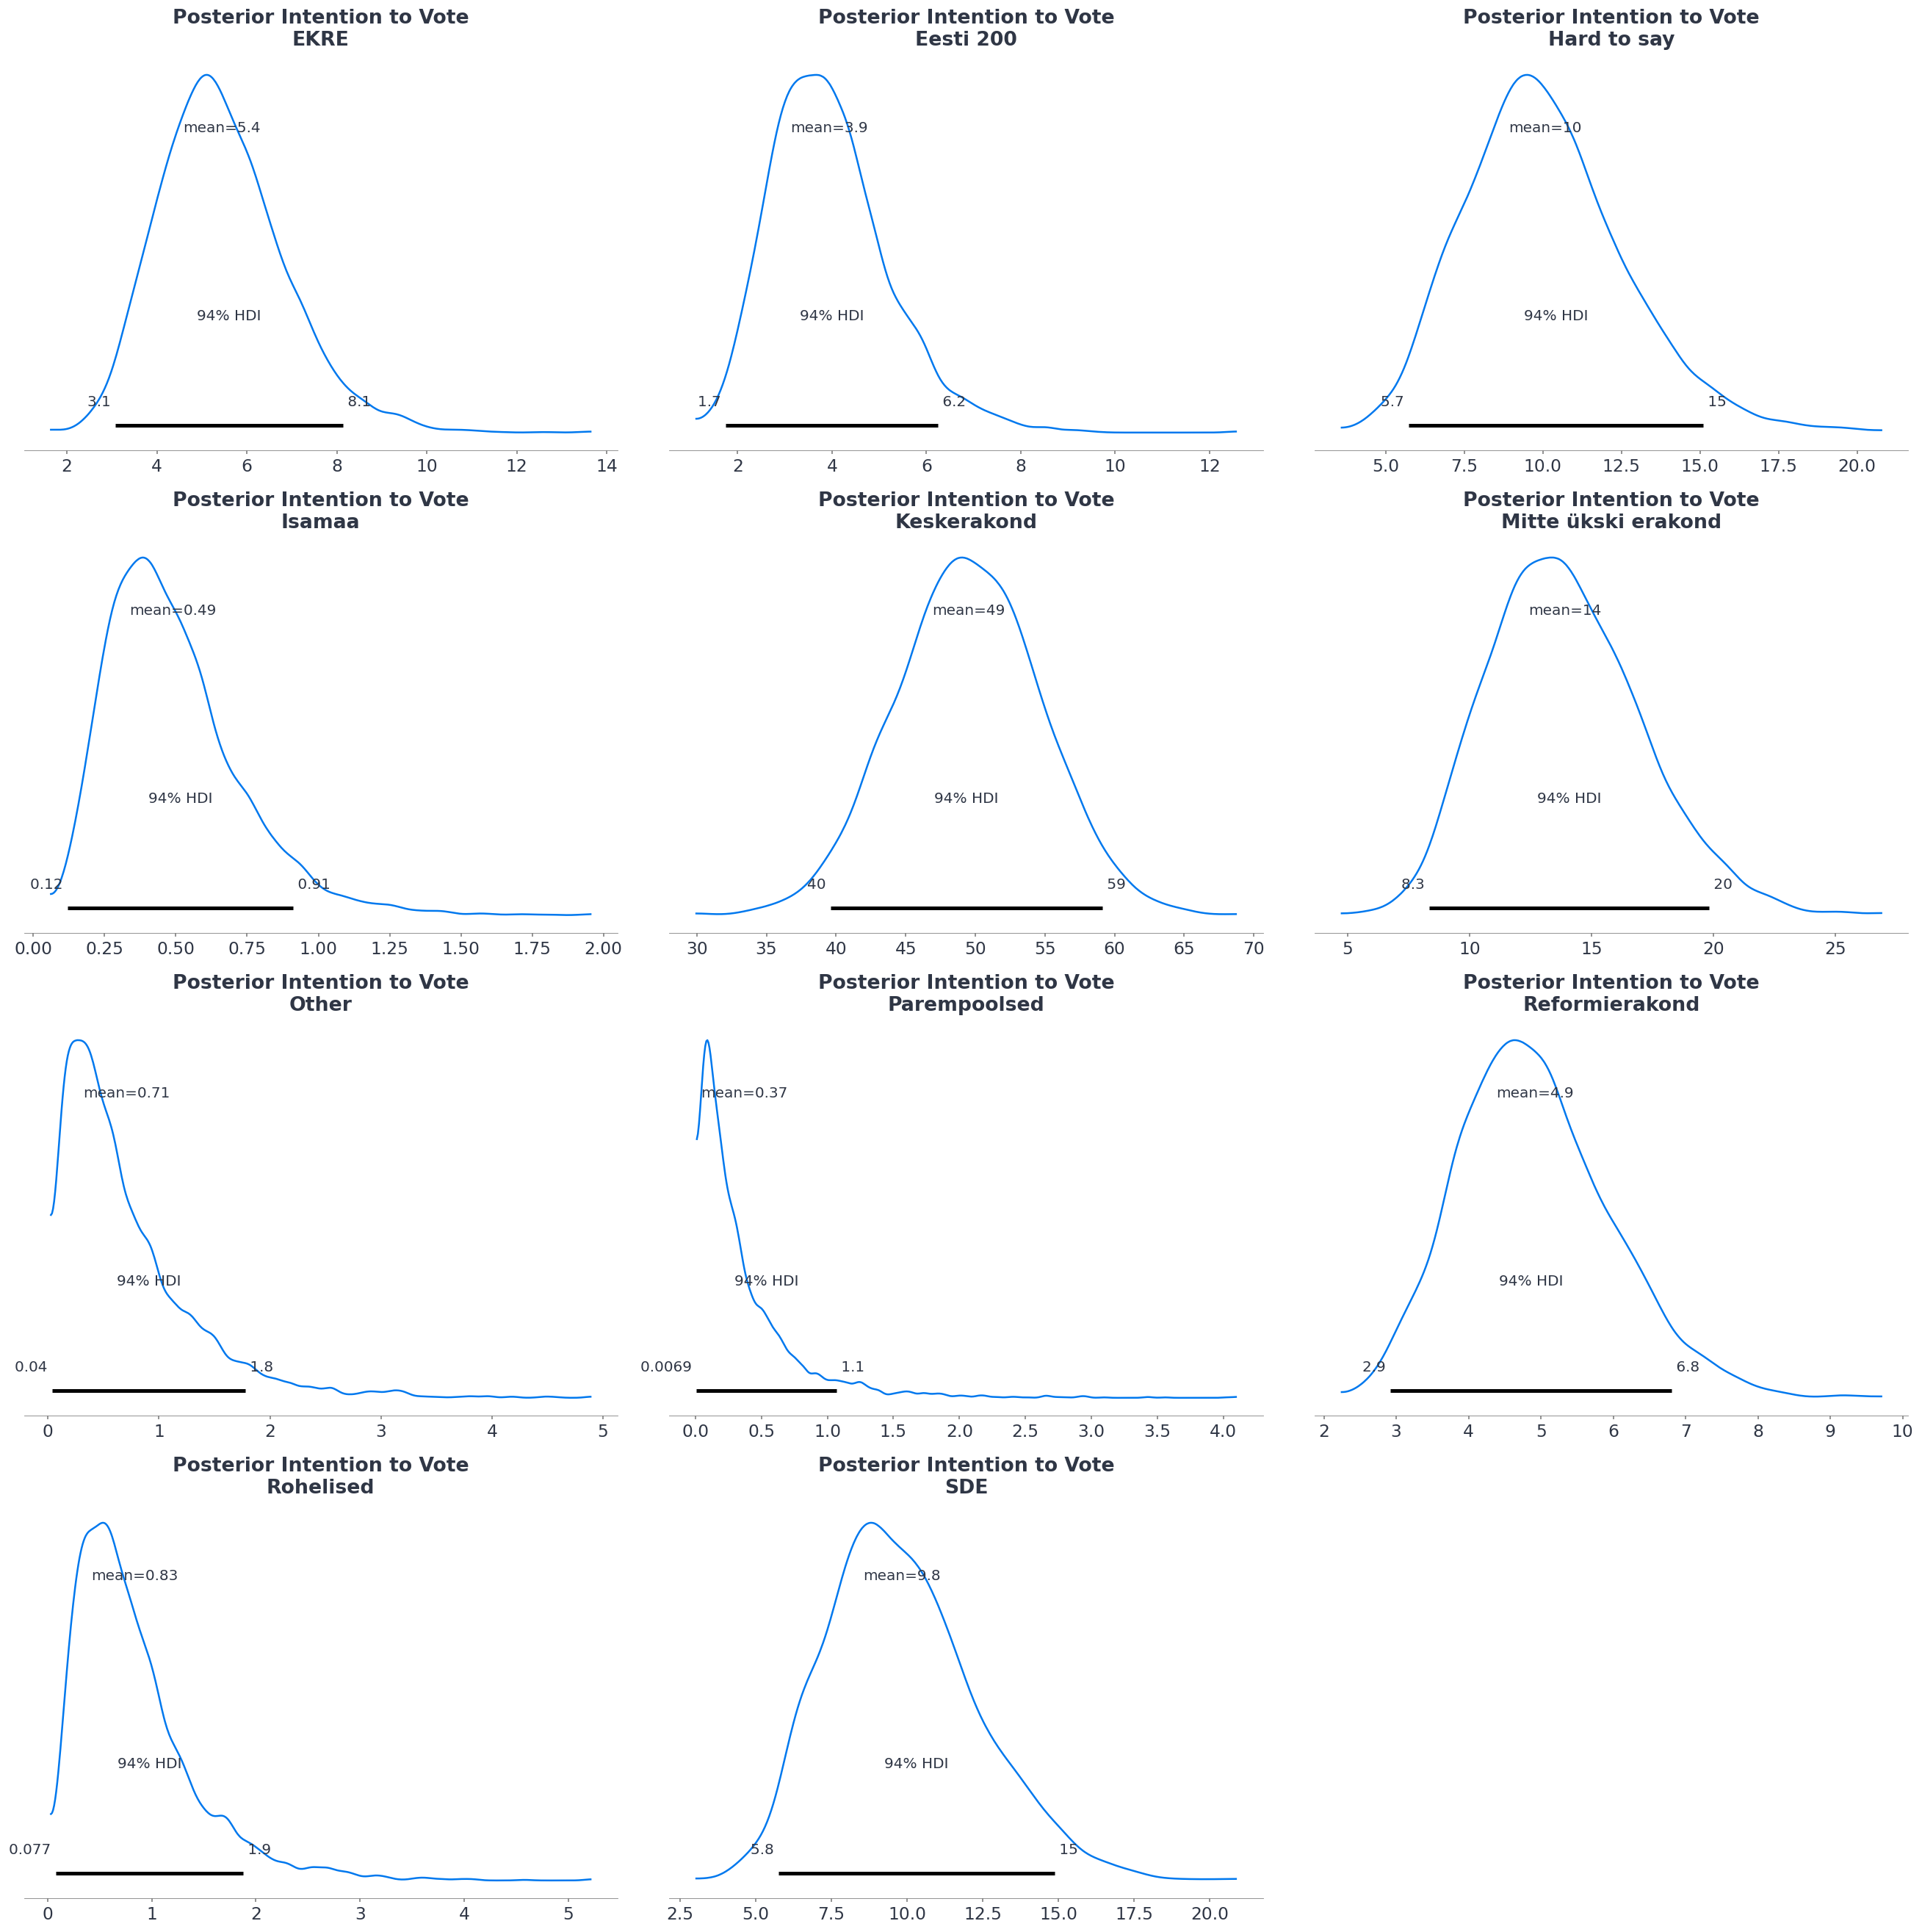

In [22]:
_, elderly_preds = plot_post_p(
    posterior=estonian_pymc_idata.posterior,
    demographics=dict(
        education="Higher education",
        nationalities="Other",
        genders="Female",
        age_groups="75+"
    )
)

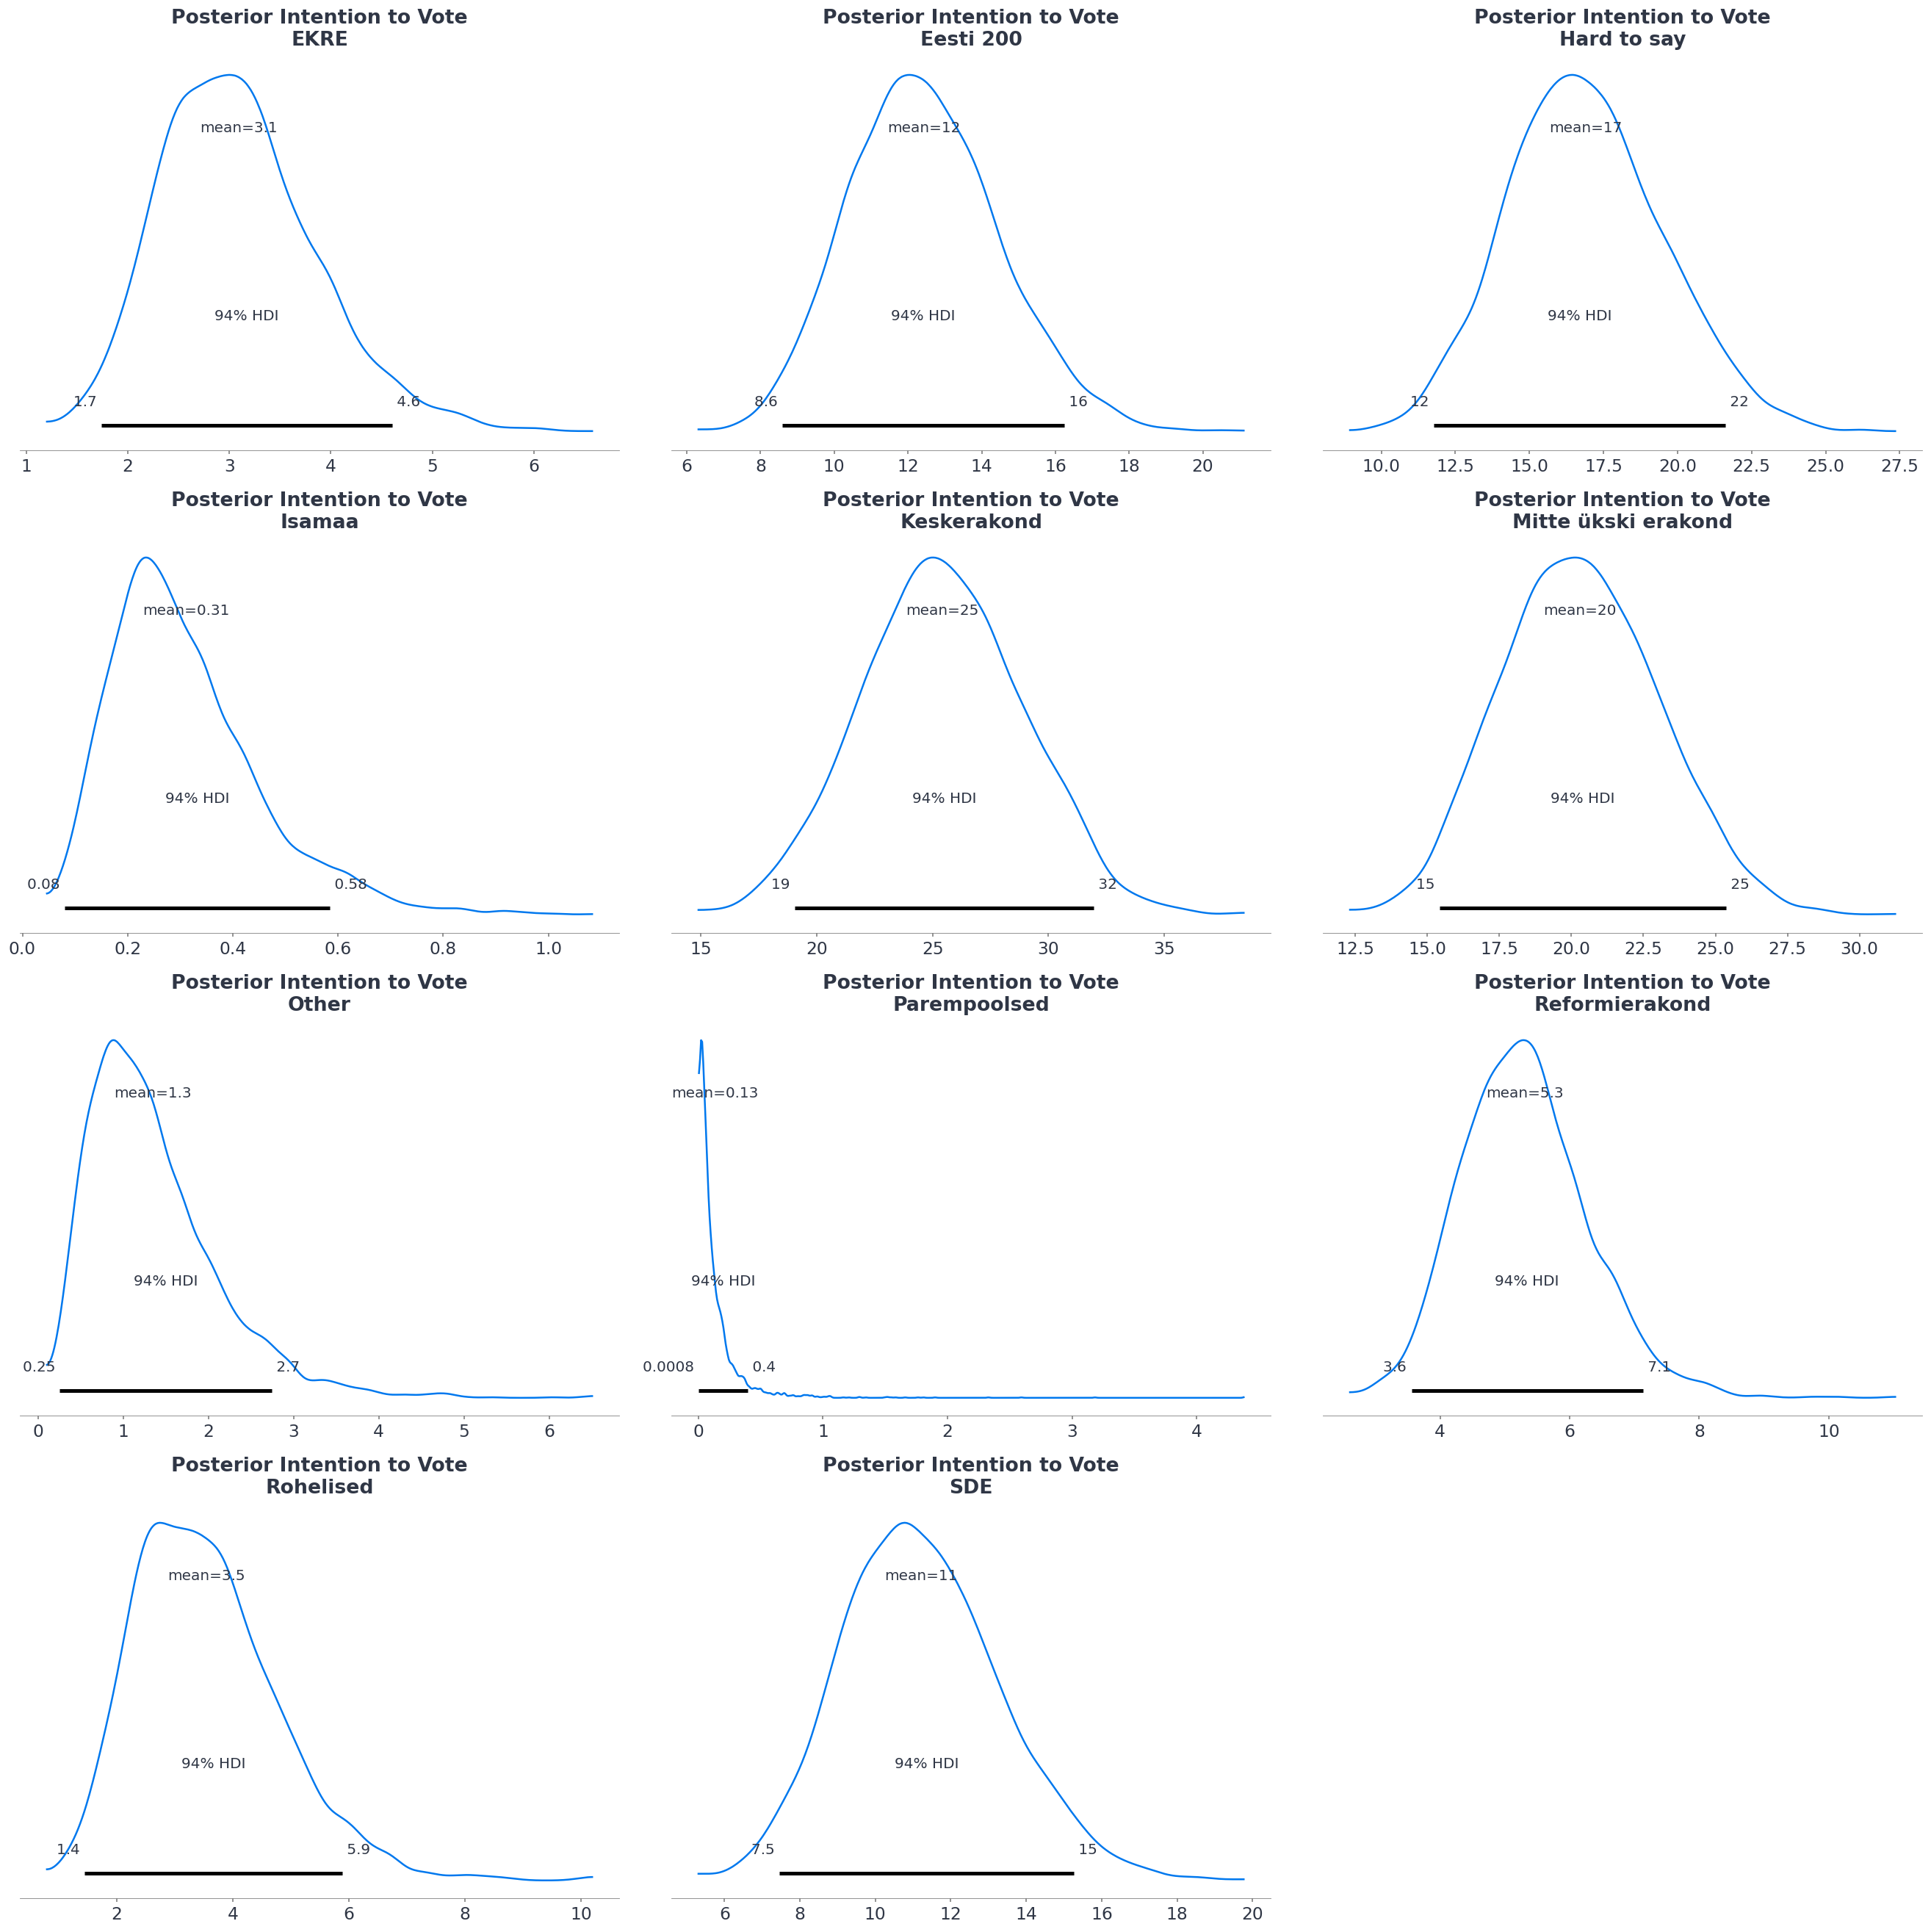

In [23]:
_, young_preds = plot_post_p(
    posterior=estonian_pymc_idata.posterior,
    demographics=dict(
        education="Higher education",
        nationalities="Other",
        genders="Female",
        age_groups="25-34"
    )
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

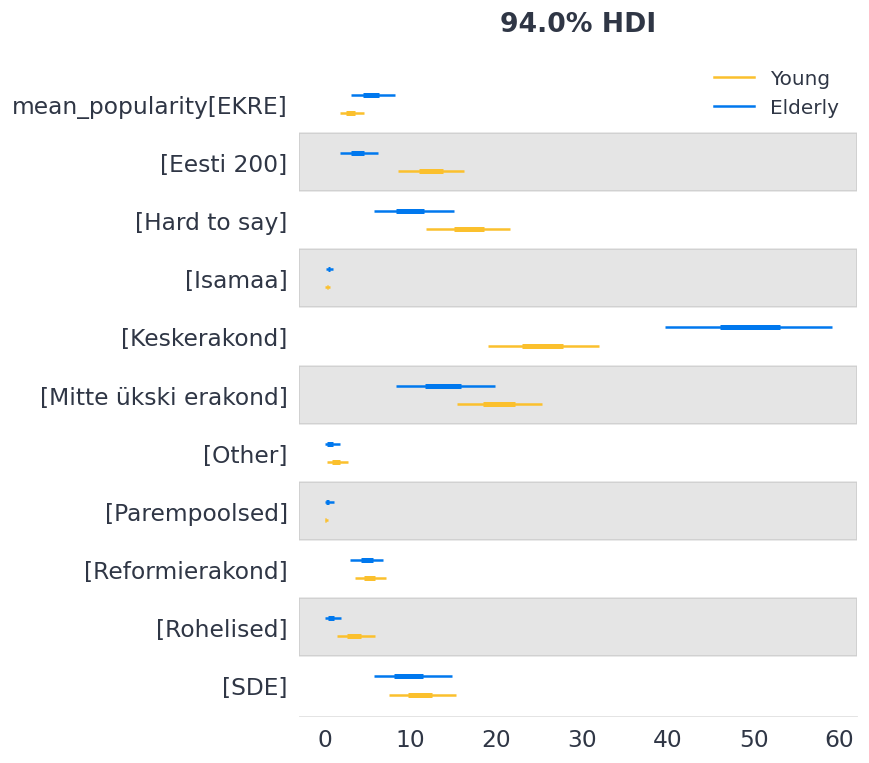

In [24]:
az.plot_forest(
    data=[elderly_preds, young_preds],
    model_names=["Elderly", "Young"],
    combined=True)
ax[0].set(title="Estimated age group difference", xlabel="Females - Males")
ax[0].axvline(color="k", ls="--", alpha=0.4, lw=2);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

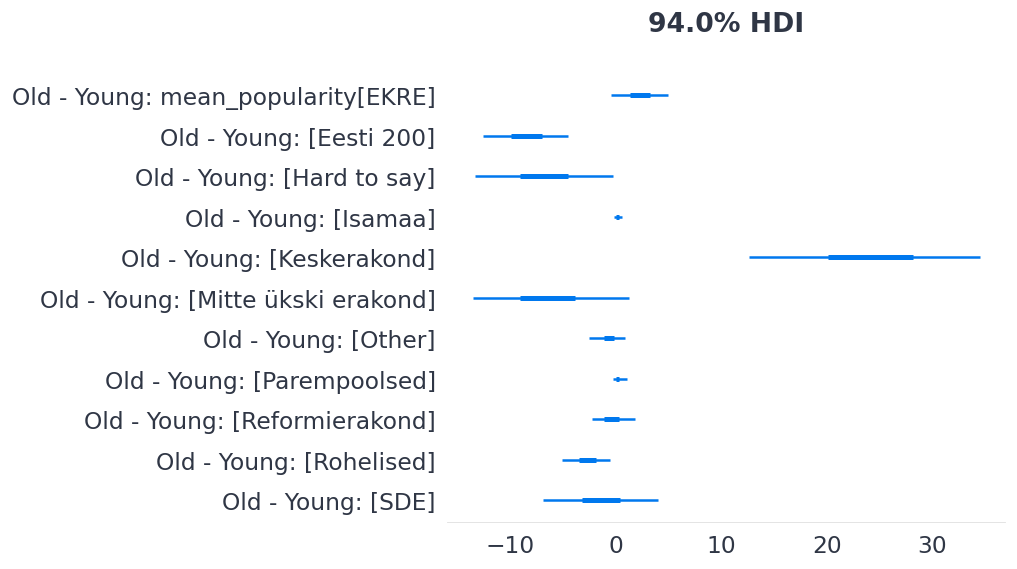

In [27]:
az.plot_forest(
    data=elderly_preds - young_preds,
    model_names=["Old - Young"],
    combined=True)

#### Predictions
* Young people seem to be more undecided ("Hard to say" is a substantially more popular answer), and clearly prefer the Eesti 200 and Mitte parties in comparison to their older peers. The latter find the Keskerakond party much more appealing.


In [31]:
estonian_test = pd.DataFrame(
    dict(
        age_group=["75+", "25-34"],
        eduction=["Higher education", "Higher education"],
        gender=["Female", "Female"],
        nationality=["Other", "Other"]
    ))
estonian_test

age_group          eduction  gender nationality
0       75+  Higher education  Female       Other
1     25-34  Higher education  Female       Other

In [36]:
estonian_bmb_model.predict(estonian_bmb_idata, data=estonian_test)

Data variables:
    age_group            (chain, draw, winning_party_reduced_dim, age_group_dim) float64 ...
    education            (chain, draw, winning_party_reduced_dim, education_dim) float64 ...
    age_group:education  (chain, draw, winning_party_reduced_dim, age_group:education_dim) float64 ...
    gender               (chain, draw, winning_party_reduced_dim, gender_dim) float64 ...
    nationality          (chain, draw, winning_party_reduced_dim, nationality_dim) float64 ...
    winning_party_mean   (chain, draw, winning_party_obs, winning_party_dim) float64 ...

In [ ]:
young_bmb_preds = (
    estonian_bmb_idata.posterior.sel(winning_party_obs=0)["winning_party_mean"]
    * 100
)
elderly_bmb_preds = (
    estonian_bmb_idata.posterior.sel(winning_party_obs=1)["winning_party_mean"]
    * 100
)

In [ ]:
az.plot_posterior(young_bmb_preds)
plt.tight_layout()

In [ ]:
az.plot_posterior(elderly_bmb_preds)
plt.tight_layout()

In [ ]:
ax = az.plot_forest(
    [young_bmb_preds, elderly_bmb_preds],
    model_names=["25-34", "75+"],
    combined=True,
    figsize=(6, 6),
)
ax[0].set_xlabel("Vote intention (%)");

In [ ]:
az.plot_forest(
    data=[young_preds, young_bmb_preds, elderly_preds, elderly_bmb_preds],
    model_names=["25-34 PyMC", "25-34 Bambi", "75+ PyMC", "75+ Bambi"],
    combined=True)

In [ ]:
# model comparison (between the difference in age groups)
az.plot_forest(
    data=[np.abs(elderly_preds) - np.abs(young_preds), np.abs(elderly_bmb_preds) - np.abs(young_bmb_preds)],
    model_names=["PyMC difference", "Bambi difference"],
    combined=True)